# Foreword

This notebook loads Globo.com Dataseet and tests several recommendation methods.
Some models will be deployed to Azure to be consumed via API, some predictions will be sent to a CosmosDB so that a mobile app can fetch them, via Azure Functions.

You'll need the following modules:

- azure-common==1.1.27
- azure-core==1.19.0
- implicit==0.4.8
- ipython==7.22.0
- jupyter==1.0.0
- lightfm==1.16
- matplotlib==3.4.3
- notebook==6.3.0
- numpy==1.21.2
- pandas==1.2.4
- python==3.8.3
- scikit-learn==0.24.1
- scipy==1.5.4
- seaborn==0.11.1
- scikit-surprise==1.1.1
- tqdm==4.59.0


# Goal

After doing an Exploratory Data Analysis (EDA), we'll try several recommendation system (content-based, collaborative based...) and some existing librairies.
I'll compare the model will recall@k and cosine_similarity mean between predictions and testset.


## Process

The following checklist will be followed.

Some research results will be summed up here for further reference, and you'll find some comments all along the notebook.
Some methods will only be tested but not retained (such as similarity kernel) due the computation time or memory needed.

Some "naive" models are also coded, to illustrate in a simple way how a model's working


## Checklist and notes

### Data Analysis   
### Feature engineering
    
- Interactions threshold
- "Unread" articles
- Using time series
- Most common categories / articles
- Weighted ratings

# Imports

In [1]:
# import modin.pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os, pickle
from tqdm.notebook import tqdm
import random, math
from operator import itemgetter
from sklearn.metrics.pairwise import sigmoid_kernel, cosine_similarity
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise import SVD, accuracy
from surprise.model_selection import train_test_split
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler, normalize, StandardScaler
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import plotly.express as px
from sklearn.metrics import mean_squared_error
from scipy.spatial import distance
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import sys
from scipy import sparse
from collections import Counter
from IPython.display import Markdown, display
import warnings
warnings.filterwarnings('ignore')

## Functions

In [2]:
plt.style.use('seaborn-whitegrid')
sns.set(style='whitegrid', palette="deep", font_scale=1.1) #, rc={"figure.figsize": [8, 5]})

In [3]:
%%capture
tqdm.pandas()

# Analysis

In [4]:
def printmd(string, color=None):
    '''
        This function extends the print function, allowing to use Markdown tags (bold, italic, colors...)
        input: string to format
        output: formatted string
    '''
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))
    
def show_distplot(var, x_label, y_label="count", bins=30):
    plt.figure()
    sns.distplot(
    var, norm_hist=False, kde=False, bins=bins, hist_kws={"alpha": 1}
    ).set(xlabel=x_label, ylabel=y_label)
    
def vc_bar(df, by, var, title, c):
    plt.subplot(1, 5, c)
    df.groupby(by=by)[var].nunique().value_counts().plot(kind = 'bar', title=title)
    
def most_common(srs):
    x = list(srs)
    counter = Counter(x)
    return counter.most_common(1)[0][0]

def least_common(srs):
    x = list(srs)
    counter = Counter(x)
    return list(counter.items())[-1][0]
def find_cat(x):
    cats = []
#     print(x, articles_meta_df[articles_meta_df['click_article_id'] == x]['category_id'])
    return [articles_meta_df[articles_meta_df['click_article_id'] == id]['category_id'].values[0] for id in x]
def display_reco(rec):
    categories = find_cat(rec)
    rec = dict(zip(rec, categories))
    for key, value in rec.items():
        print("Book {} (Category: {})".format(key, value))
        

def display_reco_pop(rec, pop):
    rec = dict(zip(rec, pop['weighted_average']))
    for key, value in rec.items():
        print("Article {} ({} readers)".format(key, value))

## Data load

<div style='background:#96d6ee;' class='alert alert-block alert-info'><span style='color: #3c6f9c'>We first group all clicks csv files into one</span></div>

In [155]:
click_path = glob.glob('clicks/*.csv')
tmp_df = []
with tqdm(total=len(click_path)) as pbar:
    for csv in click_path:
        tmp_df.append(pd.read_csv(csv))
        pbar.update(1)

clicks_df = pd.concat(tmp_df)
clicks_df.head()

  0%|          | 0/385 [00:00<?, ?it/s]

user_id        session_id  session_start session_size click_article_id  \
0       0  1506825423271737  1506825423000            2           157541   
1       0  1506825423271737  1506825423000            2            68866   
2       1  1506825426267738  1506825426000            2           235840   
3       1  1506825426267738  1506825426000            2            96663   
4       2  1506825435299739  1506825435000            2           119592   

  click_timestamp click_environment click_deviceGroup click_os click_country  \
0   1506826828020                 4                 3       20             1   
1   1506826858020                 4                 3       20             1   
2   1506827017951                 4                 1       17             1   
3   1506827047951                 4                 1       17             1   
4   1506827090575                 4                 1       17             1   

  click_region click_referrer_type  
0           20                   2  
1           20                   2  
2           16                   2  
3           16                   2  
4           24                   2

In [6]:
clicks_sample_df = pd.read_csv('clicks_sample.csv')
articles_meta_df = pd.read_csv('articles_metadata.csv')
articles_meta_df.head()

article_id  category_id  created_at_ts  publisher_id  words_count
0           0            0  1513144419000             0          168
1           1            1  1405341936000             0          189
2           2            1  1408667706000             0          250
3           3            1  1408468313000             0          230
4           4            1  1407071171000             0          162

In [7]:
articles_meta_df.rename(columns={'article_id':'click_article_id'}, inplace=True)
df = articles_meta_df.merge(clicks_df, on='click_article_id')
sample_df = articles_meta_df.merge(clicks_sample_df, on='click_article_id')
df.head()

click_article_id  category_id  created_at_ts  publisher_id  words_count  \
0                3            1  1408468313000             0          230   
1               27            1  1478811408000             0          151   
2               69            1  1368528105000             0          290   
3               81            1  1371658109000             0          202   
4               81            1  1371658109000             0          202   

  user_id        session_id  session_start session_size click_timestamp  \
0  246630  1507569563229379  1507569563000            2   1507572378399   
1   58062  1507144774359237  1507144774000            2   1507144866293   
2  289974  1507830296148001  1507830296000            3   1507832069718   
3   65902  1506954258239649  1506954258000            2   1506954288811   
4   56070  1506973960396557  1506973960000            5   1506974215111   

  click_environment click_deviceGroup click_os click_country click_region  \
0                 4                 1       17             1            8   
1                 4                 1       17             1           25   
2                 4                 1       17             1           25   
3                 4                 1       17             1            2   
4                 4                 1       17             1            7   

  click_referrer_type  
0                   5  
1                   1  
2                   5  
3                   5  
4                   1

## Data analysis

### Unique values

In [8]:
unique_df = pd.DataFrame(np.array(df.nunique()).reshape(1, -1), columns=[df.columns])
cols = ['created_at_ts', 'publisher_id', 'words_count', 'session_id','session_start', 'session_size', 'click_timestamp']
unique_df.drop(cols, axis=1, inplace=True)
display(unique_df.head())

click_article_id category_id user_id click_environment click_deviceGroup  \
0            46033         316  322897                 3                 5   

  click_os click_country click_region click_referrer_type  
0        8            11           28                   7

In [9]:
df.drop(['publisher_id', 'created_at_ts'], axis=1, inplace=True)

<div style='background:#96d6ee;' class='alert alert-block alert-info'><span style='color: #3c6f9c'>No data is missing in theses 2 datasets</span></div>

In [156]:
display(clicks_df.describe(), articles_meta_df.describe())

user_id        session_id  session_start  session_size  \
count   2988181           2988181        2988181       2988181   
unique   322897           1048594         646874            72   
top        5890  1507563657895091  1507563657000             2   
freq       1232               124            127       1260372   

        click_article_id  click_timestamp  click_environment  \
count            2988181          2988181            2988181   
unique             46033          2983198                  3   
top               160974    1507554094045                  4   
freq               37213                3            2904478   

        click_deviceGroup  click_os  click_country  click_region  \
count             2988181   2988181        2988181       2988181   
unique                  5         8             11            28   
top                     1        17              1            25   
freq              1823162   1738138        2852406        804985   

        click_referrer_type  
count               2988181  
unique                    7  
top                       2  
freq                1602601

click_article_id    category_id  created_at_ts  publisher_id  \
count     364047.000000  364047.000000   3.640470e+05      364047.0   
mean      182023.000000     283.108239   1.474070e+12           0.0   
std       105091.461061     136.723470   4.293038e+10           0.0   
min            0.000000       0.000000   1.159356e+12           0.0   
25%        91011.500000     199.000000   1.444925e+12           0.0   
50%       182023.000000     301.000000   1.489422e+12           0.0   
75%       273034.500000     399.000000   1.509891e+12           0.0   
max       364046.000000     460.000000   1.520943e+12           0.0   

         words_count  
count  364047.000000  
mean      190.897727  
std        59.502766  
min         0.000000  
25%       159.000000  
50%       186.000000  
75%       218.000000  
max      6690.000000

In [161]:
display(clicks_df.session_size.min(), clicks_df.session_size.max())

2

124

### Duplicate articles

Did someone read the same articles twice ?

In [10]:
tmp = df.groupby(['click_article_id', 'user_id'], as_index=False).size().sort_values('size', ascending=False)
display(tmp.mean(), tmp.max(), tmp.median(), tmp)
del tmp
gc.collect()

click_article_id    195029.718311
user_id             108392.082372
size                     1.012699
dtype: float64

click_article_id    364046
user_id             322896
size                    33
dtype: int64

click_article_id    202388.0
user_id              86830.0
size                     1.0
dtype: float64

click_article_id  user_id  size
341596              68851    16280    33
2018889            237071    16280    33
2950367            363925    16280    33
165928              43032    16280    31
139360              38823    16280    30
...                   ...      ...   ...
988514             158082     2724     1
988516             158082     2814     1
988517             158082     2815     1
988518             158082     2897     1
2950709            364046   303872     1

[2950710 rows x 3 columns]

NameError: name 'gc' is not defined

### Missing values

In [ ]:
display(clicks_df.isna().sum(), articles_meta_df.isna().sum())

<div style='background:#96d6ee;' class='alert alert-block alert-info'><span style='color: #3c6f9c'>No data is missing in theses 2 datasets</span></div>

### Distributions
#### Articles

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
ax = df['words_count'].hist()
ax.set_title("Words per article - full")

plt.subplot(1, 2, 2)
ax = df['words_count'].hist(range=(0,500), bins=50)
ax.set_title("Words per article - ranged")
pass;

#### Tech

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(1, 4, 1)
df.click_os.value_counts().plot.pie(legend=False,autopct='%1.1f%%', title="OS repartition")

plt.subplot(1, 4, 2)
df.click_deviceGroup.value_counts().plot.pie(legend=False,autopct='%1.1f%%', title="Device repartition")

plt.subplot(1, 4, 3)
df.click_os.value_counts().plot.pie(legend=False,autopct='%1.1f%%', title="Referrer repartition")

plt.subplot(1, 4, 4)
df["click_country"].value_counts().plot.pie(legend=False,autopct='%1.1f%%',title="Countries Repartition")
pass;

#### Categories

In [ ]:
category_df = df.groupby("category_id").agg({
    'click_article_id': 'count',
    'words_count': np.mean,
    'click_country': pd.Series.mode
})
category_df


In [ ]:
plt.figure(figsize=(15,10))
category_df = pd.DataFrame(category_df.to_records())
sorted_category_df = category_df.sort_values('click_article_id', ascending=False)
ax = sorted_category_df[sorted_category_df['click_article_id'] > 100]['click_article_id'].plot(y='click_article_id', kind='bar')
ax.set_title("Most popular categories")
pass;

In [ ]:
# unique_users = df['user_id'].nunique()
total_users = df['user_id'].count()
category_df['percentage_clicks_total_users'] = category_df['click_article_id'].apply(lambda x: x * 100 / total_users)
# category_df['clicks_total_users'] = category_df['click_article_id'].apply(lambda x: x total_users)
# display("Verifications")
print('Total articles in main dataset', df.click_article_id.count(), "Total articles in category_df", category_df.click_article_id.sum())
category_df.sort_values('percentage_clicks_total_users', ascending=False)

In [ ]:
plt.figure(figsize=(12,10))
ax = category_df[category_df['percentage_clicks_total_users'] > 0.1].sort_values('percentage_clicks_total_users', ascending=False)['percentage_clicks_total_users'].plot(y='click_article_id', kind='bar')
ax.set_title("Category repartition by click percentage")
plt.show()
pass;

In [ ]:
df.category_id.value_counts().plot.pie(legend=False,autopct='%1.1f%%', title="Category repartition")
pass;

In [ ]:
df.groupby("user_id")['click_article_id'].count()

In [11]:
click_per_category = df.groupby('category_id').count().rename(columns={'user_id': 'clicks'})['clicks']
click_per_category = pd.DataFrame(click_per_category)
click_per_category = pd.DataFrame(click_per_category.to_records())
click_per_category.sort_values("click", ascending=False)
click_per_category

KeyError: 'click'

In [ ]:
sns.jointplot(x='category_id', y='clicks', data=click_per_category)

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
data = df.groupby("user_id")['click_article_id'].nunique()
max_ = data.max()
display("Max browsed articles per user: {}".format(max_))
ax = data.value_counts().hist(range=(0, max_+10), bins=max_//20)
ax.set_title("Unique articles viewed per user")
pass;

plt.subplot(2,3,2)
data = df.groupby("user_id")['category_id'].nunique()
max_ = data.max()
display("Max categories per user: {}".format(max_))
ax = data.value_counts().hist(range=(0, max_+10), bins=max_//10)
ax.set_title("Unique categories viewed per user")
pass;

plt.subplot(2,3,3)
data = df.groupby(by='user_id')['session_size'].nunique()
max_ = data.max()
display("Max session size: {}".format(max_))
ax = data.value_counts().hist(range=(0, max_+10), bins=max_+10)
ax.set_title("Session sizes")
pass;

plt.subplot(2,3,4)
data = df.groupby("session_id")['click_article_id'].nunique()
max_ = data.max()
display("Max articles read in session: {}".format(max_))
ax = data.value_counts().hist(range=(0, max_+10))
ax.set_title("Articles read by session") 

plt.subplot(2,3,5)
data = df.groupby("session_id")['category_id'].nunique()
max_ = data.max()
display("Max browsed catagories in session: {}".format(max_))
ax = data.value_counts().hist(range=(0, max_+10), bins=max_//10)
ax.set_title("Categories browsed by session")
pass;

plt.subplot(2,3,6)
data = df.groupby("category_id")['click_article_id'].nunique()
max_ = data.max()
display("Max articles in category: {}".format(max_))
ax = data.value_counts().hist(range=(0, max_+10), bins=max_//150)
ax.set_title("Articles in categories")
pass;

# Feature engineering
## Interactions threshold

### Remove "unread" articles

We don't want articles with no or too few interactions to distrub calculations. An article with only 1 view is not relevant for now.

In [12]:
articles_with_clicks_df = df.groupby('click_article_id').size()
print('Amount of articles: %d' % len(articles_with_clicks_df))
articles_with_enough_interactions_df = articles_with_clicks_df[articles_with_clicks_df >= 5].reset_index()[['click_article_id']]
display(len(articles_with_enough_interactions_df), len(articles_meta_df))
display(articles_with_enough_interactions_df.head())

Amount of articles: 46033


13096

364047

click_article_id
0              1779
1              1799
2              1843
3              1844
4              1873

Using a subset to save computing time and train with active users

In [13]:
print('Total interactions: %d' % len(df))
clicks_count_df = df.groupby(['user_id', 'click_article_id']).size().groupby('user_id').size()
print('users: %d' % len(clicks_count_df))
enough_clicks_df = clicks_count_df[clicks_count_df >= 100].reset_index()[['user_id']]
print('Users with 100+ interactions: %d' % len(enough_clicks_df))
clicks_from_selected_users_df = df.merge(enough_clicks_df, 
               how = 'right',
               left_on = 'user_id',
               right_on = 'user_id')
print('Clicks from users with at least 100 clicks: %d' % len(clicks_from_selected_users_df))

Total interactions: 2988181
users: 322897
Users with 100+ interactions: 1044
Clicks from users with at least 100 clicks: 162548


We only keep these interactions

In [14]:
clicks_from_selected_users_df = clicks_from_selected_users_df[~clicks_from_selected_users_df['click_article_id']\
                                                              .isin(articles_with_enough_interactions_df.index)]
clicks_from_selected_users_df

click_article_id  category_id  words_count user_id        session_id  \
1                 31805           26          175      24  1507850197406963   
2                 36399           43          229      24  1507738453356761   
3                 36399           43          229      24  1507761205327729   
4                 42612           67          156      24  1507386199143233   
5                 42612           67          156      24  1507388753250106   
...                 ...          ...          ...     ...               ...   
162543           337441          437          206  253733  1507922954282063   
162544           348112          442          168  253733  1507807129314396   
162545           348486          442          206  253733  1508188266675234   
162546           352979          442          169  253733  1508188266675234   
162547           362914          455          219  253733  1508188266675234   

        session_start session_size click_timestamp click_environment  \
1       1507850197000            4   1507850945794                 4   
2       1507738453000            5   1507747100710                 4   
3       1507761205000            3   1507761568512                 4   
4       1507386199000            3   1507386290953                 4   
5       1507388753000            3   1507388777533                 4   
...               ...          ...             ...               ...   
162543  1507922954000            6   1507923594183                 2   
162544  1507807129000            3   1507807188476                 2   
162545  1508188266000           11   1508189495173                 2   
162546  1508188266000           11   1508189359351                 2   
162547  1508188266000           11   1508188539132                 2   

       click_deviceGroup click_os click_country click_region  \
1                      1       17             1           25   
2                      1       17             1           25   
3                      1       17             1           25   
4                      1       17             1           25   
5                      1       17             1           25   
...                  ...      ...           ...          ...   
162543                 4        2             8           28   
162544                 4        2             8           28   
162545                 4        2             8           28   
162546                 4        2             8           28   
162547                 4        2             8           28   

       click_referrer_type  
1                        1  
2                        1  
3                        1  
4                        1  
5                        1  
...                    ...  
162543                   1  
162544                   2  
162545                   1  
162546                   1  
162547                   1  

[159776 rows x 14 columns]

In [15]:
df = clicks_from_selected_users_df.copy()

A bit of memory management

In [16]:
import gc
del clicks_count_df, clicks_from_selected_users_df, clicks_df, enough_clicks_df, articles_with_clicks_df, articles_with_enough_interactions_df
gc.collect()

78

Dropping unused columns. We could have kept "created_at", and recommend more recent than old articles

In [17]:
df.drop(['click_environment', 'click_deviceGroup', 'click_country', 'click_os', 'click_referrer_type'], axis=1, inplace=True)
df

click_article_id  category_id  words_count user_id        session_id  \
1                 31805           26          175      24  1507850197406963   
2                 36399           43          229      24  1507738453356761   
3                 36399           43          229      24  1507761205327729   
4                 42612           67          156      24  1507386199143233   
5                 42612           67          156      24  1507388753250106   
...                 ...          ...          ...     ...               ...   
162543           337441          437          206  253733  1507922954282063   
162544           348112          442          168  253733  1507807129314396   
162545           348486          442          206  253733  1508188266675234   
162546           352979          442          169  253733  1508188266675234   
162547           362914          455          219  253733  1508188266675234   

        session_start session_size click_timestamp click_region  
1       1507850197000            4   1507850945794           25  
2       1507738453000            5   1507747100710           25  
3       1507761205000            3   1507761568512           25  
4       1507386199000            3   1507386290953           25  
5       1507388753000            3   1507388777533           25  
...               ...          ...             ...          ...  
162543  1507922954000            6   1507923594183           28  
162544  1507807129000            3   1507807188476           28  
162545  1508188266000           11   1508189495173           28  
162546  1508188266000           11   1508189359351           28  
162547  1508188266000           11   1508188539132           28  

[159776 rows x 9 columns]

## Time series

Converting timestamps to datetime to manipulate the values

In [18]:
df['session_start_date'] = pd.to_datetime(
    df['session_start'], unit='ms')
df['click_date'] = pd.to_datetime(
    df['click_timestamp'], unit='ms')
df.head()

click_article_id  category_id  words_count user_id        session_id  \
1            31805           26          175      24  1507850197406963   
2            36399           43          229      24  1507738453356761   
3            36399           43          229      24  1507761205327729   
4            42612           67          156      24  1507386199143233   
5            42612           67          156      24  1507388753250106   

   session_start session_size click_timestamp click_region  \
1  1507850197000            4   1507850945794           25   
2  1507738453000            5   1507747100710           25   
3  1507761205000            3   1507761568512           25   
4  1507386199000            3   1507386290953           25   
5  1507388753000            3   1507388777533           25   

   session_start_date              click_date  
1 2017-10-12 23:16:37 2017-10-12 23:29:05.794  
2 2017-10-11 16:14:13 2017-10-11 18:38:20.710  
3 2017-10-11 22:33:25 2017-10-11 22:39:28.512  
4 2017-10-07 14:23:19 2017-10-07 14:24:50.953  
5 2017-10-07 15:05:53 2017-10-07 15:06:17.533

## Reading time per article

<div style='background:#96d6ee;' class='alert alert-block alert-info'><span style='color: #3c6f9c'>This is computing intensive, we'll then use click_sample dataset for a POC</span></div>

In [165]:
sample_df['session_start_date'] = pd.to_datetime(
    sample_df['session_start'], unit='ms')
sample_df['click_date'] = pd.to_datetime(
    sample_df['click_timestamp'], unit='ms')

In [166]:
# Groupby user and sort by click_date
sample_df = sample_df.groupby(["user_id"]).apply(lambda x: x.sort_values(["click_date"], ascending = True)).reset_index(drop=True)

# Calculate the time spent on each article, in seconds
sample_df['time_spent'] = sample_df.groupby('user_id')['click_timestamp'].apply(lambda x : round((x - x.shift(1)) / 1000))

# Special case for 1st article, assuming reading starts at session start
sample_df['time_spent'] = sample_df.apply(lambda x: (x['click_date'] - x['session_start_date']) /pd.offsets.Second(1) if pd.isnull(x['time_spent']) else x['time_spent'], axis=1)

sample_df[sample_df["user_id"] == 64]

click_article_id  category_id  created_at_ts  publisher_id  words_count  \
158            119592          247  1506784316000             0          239   
159            236294          375  1506786023000             0          151   
160            235840          375  1506807839000             0          159   
161            235325          375  1506756825000             0          302   
162            293182          421  1506801520000             0          202   
163            292980          421  1506803187000             0          181   
164            293264          421  1506669357000             0          236   
165            168868          297  1506796851000             0          147   
166            293285          421  1506689978000             0          172   
167            157132          281  1506824718000             0          217   
168              4243            1  1506791168000             0          225   
169             68866          136  1506816482000             0          226   
170            331813          436  1506775379000             0          171   
171            158964          281  1506765661000             0          423   
172             30970           26  1506773595000             0          216   
173            234853          375  1506773889000             0          140   

     user_id        session_id  session_start  session_size  click_timestamp  \
158       64  1506826382352801  1506826382000            16    1506826989603   
159       64  1506826382352801  1506826382000            16    1506827034225   
160       64  1506826382352801  1506826382000            16    1506827106551   
161       64  1506826382352801  1506826382000            16    1506827361945   
162       64  1506826382352801  1506826382000            16    1506830113238   
163       64  1506826382352801  1506826382000            16    1506830231928   
164       64  1506826382352801  1506826382000            16    1506830318192   
165       64  1506826382352801  1506826382000            16    1506830772373   
166       64  1506826382352801  1506826382000            16    1506844012761   
167       64  1506826382352801  1506826382000            16    1506844136203   
168       64  1506826382352801  1506826382000            16    1506844296864   
169       64  1506826382352801  1506826382000            16    1506844395842   
170       64  1506826382352801  1506826382000            16    1506844531760   
171       64  1506826382352801  1506826382000            16    1506845853180   
172       64  1506826382352801  1506826382000            16    1506846372669   
173       64  1506826382352801  1506826382000            16    1506846402669   

     click_environment  click_deviceGroup  click_os  click_country  \
158                  4                  1        17              1   
159                  4                  1        17              1   
160                  4                  1        17              1   
161                  4                  1        17              1   
162                  4                  1        17              1   
163                  4                  1        17              1   
164                  4                  1        17              1   
165                  4                  1        17              1   
166                  4                  1        17              1   
167                  4                  1        17              1   
168                  4                  1        17              1   
169                  4                  1        17              1   
170                  4                  1        17              1   
171                  4                  1        17              1   
172                  4                  1        17              1   
173                  4                  1        17              1   

     click_region  click_referrer_type  session_start_date  \
158            25             

In [167]:
display(sample_df.time_spent.min(), sample_df.time_spent.max(), sample_df.time_spent.mean())

0.0

164538.779

727.0305969198095

<div style='background:#96d6ee;' class='alert alert-block alert-info'><span style='color: #3c6f9c'>164538 seconds is 45h.. We don't have session end so we wouldd have to remove outliers or impute them if we were to use this</span></div>

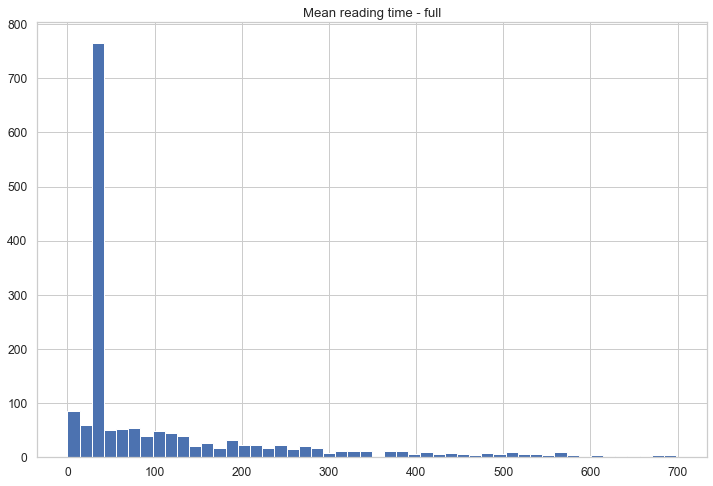

In [20]:
plt.figure(figsize=(12,8))
ax = sample_df[sample_df['time_spent']< 700].time_spent.hist(bins=50)
ax.set_title("Mean reading time - full")
pass;

## Most common + list

Let's create a dataframe where we can see each user's preferred category/article, and category/article/list

In [21]:
df.groupby('user_id').head()

click_article_id  category_id  words_count user_id        session_id  \
1                 31805           26          175      24  1507850197406963   
2                 36399           43          229      24  1507738453356761   
3                 36399           43          229      24  1507761205327729   
4                 42612           67          156      24  1507386199143233   
5                 42612           67          156      24  1507388753250106   
...                 ...          ...          ...     ...               ...   
162450            16087            7          189  253733  1507922954282063   
162451            16346            7          215  253733  1508201936187569   
162452            16765            7          165  253733  1508128269110753   
162453            20691            9          226  253733  1507865688371806   
162454            30771           26          196  253733  1507668356425474   

        session_start session_size click_timestamp click_region  \
1       1507850197000            4   1507850945794           25   
2       1507738453000            5   1507747100710           25   
3       1507761205000            3   1507761568512           25   
4       1507386199000            3   1507386290953           25   
5       1507388753000            3   1507388777533           25   
...               ...          ...             ...          ...   
162450  1507922954000            6   1507924096093           28   
162451  1508201936000            9   1508206578301           28   
162452  1508128269000           12   1508128791941           28   
162453  1507865688000            6   1507866262210           28   
162454  1507668356000            4   1507668805853           28   

        session_start_date              click_date  
1      2017-10-12 23:16:37 2017-10-12 23:29:05.794  
2      2017-10-11 16:14:13 2017-10-11 18:38:20.710  
3      2017-10-11 22:33:25 2017-10-11 22:39:28.512  
4      2017-10-07 14:23:19 2017-10-07 14:24:50.953  
5      2017-10-07 15:05:53 2017-10-07 15:06:17.533  
...                    ...                     ...  
162450 2017-10-13 19:29:14 2017-10-13 19:48:16.093  
162451 2017-10-17 00:58:56 2017-10-17 02:16:18.301  
162452 2017-10-16 04:31:09 2017-10-16 04:39:51.941  
162453 2017-10-13 03:34:48 2017-10-13 03:44:22.210  
162454 2017-10-10 20:45:56 2017-10-10 20:53:25.853  

[5217 rows x 11 columns]

In [22]:
# # clicks_df.groupby(['user_id', 'click_article_id']).size()

list_df = df.groupby(['user_id']).agg({
    'category_id': [most_common, least_common, lambda x: list(x)],
    'click_article_id': [most_common, least_common, lambda x: list(x)],
    
})

list_df.columns = list_df.columns.to_flat_index().str.join('_')
list_df.rename(columns={
    'category_id_<lambda_0>': 'category_list',
    'click_article_id_<lambda_0>': 'article_list',
    'click_article_id_least_common': 'article_id_least_common',
    'click_article_id_most_common': 'article_id_most_common',
    'user_id_': 'user_id',
    'click_article_id_first': 'click_article_id'
}, inplace=True)
# df = df.merge(list_df, on="user_id")
list_df = list_df.merge(df[['user_id', 'click_region']], on='user_id')
list_df

user_id  category_id_most_common  category_id_least_common  \
0            24                      281                       450   
1            24                      281                       450   
2            24                      281                       450   
3            24                      281                       450   
4            24                      281                       450   
...         ...                      ...                       ...   
159771   253733                      412                       455   
159772   253733                      412                       455   
159773   253733                      412                       455   
159774   253733                      412                       455   
159775   253733                      412                       455   

                                            category_list  \
0       [26, 43, 43, 67, 67, 67, 67, 67, 118, 118, 133...   
1       [26, 43, 43, 67, 67, 67, 67, 67, 118, 118, 133...   
2       [26, 43, 43, 67, 67, 67, 67, 67, 118, 118, 133...   
3       [26, 43, 43, 67, 67, 67, 67, 67, 118, 118, 133...   
4       [26, 43, 43, 67, 67, 67, 67, 67, 118, 118, 133...   
...                                                   ...   
159771  [7, 7, 7, 9, 26, 26, 26, 43, 43, 92, 118, 118,...   
159772  [7, 7, 7, 9, 26, 26, 26, 43, 43, 92, 118, 118,...   
159773  [7, 7, 7, 9, 26, 26, 26, 43, 43, 92, 118, 118,...   
159774  [7, 7, 7, 9, 26, 26, 26, 43, 43, 92, 118, 118,...   
159775  [7, 7, 7, 9, 26, 26, 26, 43, 43, 92, 118, 118,...   

        article_id_most_common  article_id_least_common  \
0                       157798                   357730   
1                       157798                   357730   
2                       157798                   357730   
3                       157798                   357730   
4                       157798                   357730   
...                        ...                      ...   
159771                   16087                   362914   
159772                   16087                   362914   
159773                   16087                   362914   
159774                   16087                   362914   
159775                   16087                   362914   

                                             article_list click_region  
0       [31805, 36399, 36399, 42612, 42612, 42612, 426...           25  
1       [31805, 36399, 36399, 42612, 42612, 42612, 426...           25  
2       [31805, 36399, 36399, 42612, 42612, 42612, 426...           25  
3       [31805, 36399, 36399, 42612, 42612, 42612, 426...           25  
4       [31805, 36399, 36399, 42612, 42612, 42612, 426...           25  
...                                                   ...          ...  
159771  [16087, 16346, 16765, 20691, 30771, 31053, 320...           28  
159772  [16087, 16346, 16765, 20691, 30771, 31053, 320...           28  
159773  [16087, 16346, 16765, 20691, 30771, 31053, 320...           28  
159774  [16087, 16346, 16765, 20691, 30771, 31053, 320...           28  
159775  [16087, 16346, 16765, 20691, 30771, 31053, 320...           28  

[159776 rows x 8 columns]

# Compute and weight interactions

A visit during a 2-articles session will give more weight to the article than 1 read in a 100-articles session
If the article is already read, give it more weight 
1 read in a session of size 3 = 0.33 weight. if the article is read for the 10th time, do x 10
I normalize all weights with MinMax to smooth

We could also weight with time elapsed between each read. We really miss some metrics here, such as share, which is a HUGE indicator of similarity.

In [19]:
interactions = df[['user_id', 'click_article_id', 'session_size', 'session_id', 'session_start_date', 'click_timestamp']]
interactions =interactions.groupby(['user_id', 'session_id', 'click_article_id', 'session_start_date', 'click_timestamp']).size().reset_index().rename(columns={0:'visit_per_session'})

sessions=interactions.groupby(['user_id', 'session_id', 'session_start_date']).size().sort_values(ascending=False).reset_index().rename(columns={0:'session_size'})

click_on_articles = interactions.groupby(['user_id', 'click_article_id']).size().reset_index().rename(columns={0:'total_clicks_on_article'})
interactions = interactions.merge(sessions[['session_id','session_size']], on="session_id")
interactions = interactions.merge(click_on_articles, on=["user_id", "click_article_id"])

interactions['weighted_average'] = (interactions['visit_per_session'] / interactions['session_size']) * interactions['total_clicks_on_article']

scaler=MinMaxScaler()
interactions['weighted_average'] = scaler.fit_transform(interactions[['weighted_average']])
interactions.drop(['visit_per_session', 'session_size','total_clicks_on_article'], axis=1, inplace=True)
interactions


user_id        session_id  click_article_id  session_start_date  \
0            24  1506825812326761             69341 2017-10-01 02:43:32   
1            24  1506825812326761            161498 2017-10-01 02:43:32   
2            24  1506825812326761            162286 2017-10-01 02:43:32   
3            24  1506825812326761            287174 2017-10-01 02:43:32   
4            24  1506886161116517            159581 2017-10-01 19:29:21   
...         ...               ...               ...                 ...   
159771   253733  1508201936187569            129905 2017-10-17 00:58:56   
159772   253733  1508201936187569            211442 2017-10-17 00:58:56   
159773   253733  1508201936187569            212234 2017-10-17 00:58:56   
159774   253733  1508201936187569            224730 2017-10-17 00:58:56   
159775   253733  1508201936187569            308315 2017-10-17 00:58:56   

        click_timestamp  weighted_average  
0         1506829402915          0.028490  
1         1506829372915          0.028490  
2         1506827029118          0.028490  
3         1506828507322          0.028490  
4         1506886208819          0.116809  
...                 ...               ...  
159771    1508205084315          0.012135  
159772    1508204783470          0.012135  
159773    1508205385386          0.012135  
159774    1508204973986          0.012135  
159775    1508205980776          0.012135  

[159776 rows x 6 columns]

In [20]:
import gc
del click_on_articles, sessions
gc.collect()

46

# Embeddings

<div style='background:#96d6ee;' class='alert alert-block alert-info'><span style='color: #3c6f9c'>For a basic  recommandation algorithm using embeddings, we can build take user's last read article and use this embedding average against similar articles averages</span></div>

In [21]:
import joblib
emb = joblib.load('articles_embeddings.pickle')

emb_df = pd.DataFrame(data=emb, index=range(0, emb.shape[0]))
emb_df['average'] = emb_df.mean(axis=1)
emb_df.head()

0         1         2         3         4         5         6  \
0 -0.161183 -0.957233 -0.137944  0.050855  0.830055  0.901365 -0.335148   
1 -0.523216 -0.974058  0.738608  0.155234  0.626294  0.485297 -0.715657   
2 -0.619619 -0.972960 -0.207360 -0.128861  0.044748 -0.387535 -0.730477   
3 -0.740843 -0.975749  0.391698  0.641738 -0.268645  0.191745 -0.825593   
4 -0.279052 -0.972315  0.685374  0.113056  0.238315  0.271913 -0.568816   

          7         8         9  ...       241       242       243       244  \
0 -0.559561 -0.500603  0.165183  ...  0.313999  0.636412  0.169179  0.540524   
1 -0.897996 -0.359747  0.398246  ...  0.823124  0.412688 -0.338654  0.320787   
2 -0.066126 -0.754899 -0.242004  ...  0.473184  0.377866 -0.863887 -0.383365   
3 -0.710591 -0.040099 -0.110514  ...  0.036040  0.480029 -0.763173  0.022627   
4  0.341194 -0.600554 -0.125644  ...  0.809268  0.427521 -0.615932 -0.503697   

        245       246       247       248       249   average  
0 -0.813182  0.286870 -0.231686  0.597416  0.409623  0.001296  
1  0.588643 -0.594137  0.182828  0.397090 -0.834364  0.018029  
2  0.137721 -0.810877 -0.447580  0.805932 -0.285284 -0.013301  
3  0.565165 -0.910286 -0.537838  0.243541 -0.885329 -0.047633  
4  0.614450 -0.917760 -0.424061  0.185484 -0.580292 -0.007956  

[5 rows x 251 columns]

# Split data

We'll split data for training and testing purposes

<div style='background:#96d6ee;' class='alert alert-block alert-info'><span style='color: #3c6f9c'>We will do classic split here, sampling randomly (with stratification). We could split data by date. eg: Oct 1st to Oct 20th for  training, Oct 21st to Oct 31st for testing. This will be more realistic, as we try to "predict the future" of what users will read, but we don't have enough data to evaluate our models. Moreover, we can't stratify if we use dates. Hence, some user could be in trainset but not in testset.</span></div>

In [22]:
interactions

user_id        session_id  click_article_id  session_start_date  \
0            24  1506825812326761             69341 2017-10-01 02:43:32   
1            24  1506825812326761            161498 2017-10-01 02:43:32   
2            24  1506825812326761            162286 2017-10-01 02:43:32   
3            24  1506825812326761            287174 2017-10-01 02:43:32   
4            24  1506886161116517            159581 2017-10-01 19:29:21   
...         ...               ...               ...                 ...   
159771   253733  1508201936187569            129905 2017-10-17 00:58:56   
159772   253733  1508201936187569            211442 2017-10-17 00:58:56   
159773   253733  1508201936187569            212234 2017-10-17 00:58:56   
159774   253733  1508201936187569            224730 2017-10-17 00:58:56   
159775   253733  1508201936187569            308315 2017-10-17 00:58:56   

        click_timestamp  weighted_average  
0         1506829402915          0.028490  
1         1506829372915          0.028490  
2         1506827029118          0.028490  
3         1506828507322          0.028490  
4         1506886208819          0.116809  
...                 ...               ...  
159771    1508205084315          0.012135  
159772    1508204783470          0.012135  
159773    1508205385386          0.012135  
159774    1508204973986          0.012135  
159775    1508205980776          0.012135  

[159776 rows x 6 columns]

In [23]:
#Keeping this one apart since surprise uses the same function name
from sklearn.model_selection import train_test_split as sk_tts

interactions = interactions.sort_values('click_timestamp').drop(['session_start_date', 'click_timestamp', 'session_id'], axis=1)
# interactions_train = interactions[(interactions['session_start_date'] > '2017-10-01') & (interactions['session_start_date'] < '2017-10-10')]
# interactions_test = interactions[(interactions['session_start_date'] >= '2017-10-10') & (interactions['session_start_date'] < '2017-10-18')]
# interactions.drop(['session_id', 'session_start_date'], axis=1, inplace=True)
interactions_train, interactions_test = sk_tts(interactions,
                                   stratify=interactions['user_id'], 
                                   test_size=0.20,
                                   random_state=42)

# display(interactions_train.shape, interactions_test.shape)
# interactions_train = interactions_train.sort_values('click_timestamp').drop(['session_start_date','click_timestamp', 'session_id'], axis=1)
# interactions_test = interactions_test.sort_values('click_timestamp').drop(['session_start_date','click_timestamp', 'session_id'], axis=1)
# # we want to "predict" the future so we order by visit date ascending


Indexing for better search speed

In [24]:
interactions_indexed = interactions.set_index('user_id')
interactions_train_indexed = interactions_train.set_index('user_id')
interactions_test_indexed = interactions_test.set_index('user_id')

# Evaluator

This class will run the selected model for each user, and compile mean precision and recall

<div style='background:#96d6ee;' class='alert alert-block alert-info'><span style='color: #3c6f9c'>Do to the huge time of compute needed to evaluate all users on all availables items, I will evaluate 100 random users. The metrics will of course be affected, but this will still allow us to somewhat compare our models </span></div>

In [25]:
# Which articles did the user read
def get_interacted_items(user_id, interactions_df):
#     display("inter df", interactions_df)
    interacted_items = interactions_df.loc[user_id]['click_article_id']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

## Similarity evaluation

In [26]:
from ml_metrics import mapk

In [27]:
class SimilarityEvaluator:
    
    def __init__(self, trainset, testset):
        self.trainset = trainset
        self.testset = testset
    
    def compute_mapk(self, y_pred, y_true):
#         display(y_true[0:5]['click_article_id'].values.tolist())
        mapk_5 = mapk([y_true[0:5]['click_article_id'].values.tolist()], [y_pred[0:5]['click_article_id'].values.tolist()])
        mapk_10 = mapk([y_true[0:10]['click_article_id'].values.tolist()], [y_pred[0:10]['click_article_id'].values.tolist()])
       
        return mapk_5, mapk_10
    
    def compute_similarity(self, y_pred, y_true, n=10):
        recos_emb = emb_df.iloc[y_pred[0:n]['click_article_id'].values]
        test_emb = emb_df.iloc[y_true[0:n]['click_article_id'].values]

        return cosine_similarity(recos_emb, test_emb).mean()
    
    def recall(self, y_pred, y_true, k):
#         display(y_true, y_pred)
        threshold = y_true['weighted_average'].mean()
       # relevent
        
        n_rel = sum((true_ >= threshold) for true_ in y_true['weighted_average'])
        # recommended
        n_rec_k = sum((pred_ >= threshold) for pred_ in y_pred['weighted_average'][:k])
        # relevent and recommended
        n_rel_and_rec_k = sum((true_ >= threshold for y_true in y_true['weighted_average'][:k]) \
                               and (pred_ >= threshold for pred_ in y_pred['weighted_average'][:k]))
        recall = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        return recall
    
    def evaluate_model_user(self, model, user_id):
        interacted_values_testset = self.trainset.loc[user_id]#.sort_values('weighted_average', ascending=False)

        if type(interacted_values_testset['click_article_id']) == pd.Series:
            person_interacted_items_testset = interacted_values_testset
        else:
            person_interacted_items_testset = [int(interacted_values_testset)]  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        person_recs_df = model.recommend_items(user_id, 
                                               items_to_ignore=get_interacted_items(user_id, self.trainset ), 
                                               topn=1000)
#         display(person_recs_df)
        if person_recs_df.shape[0] == 0:
            return 0
#         self.recall(person_interacted_items_testset, person_recs_df, 10)
        sim_5 = self.compute_similarity(person_recs_df, person_interacted_items_testset, 5)
        sim_10 = self.compute_similarity(person_recs_df, person_interacted_items_testset, 10)

        mapk_5, mapk_10 = self.compute_mapk(person_recs_df, person_interacted_items_testset)
        recall_5 = self.recall(person_recs_df, person_interacted_items_testset, 5)
        recall_10 = self.recall(person_recs_df, person_interacted_items_testset, 10)

        user_metrics = {'interacted_count': interacted_items_count_testset,\
                          'sim@5': sim_5,'sim@10': sim_10,\
                         'mapk@5': mapk_5,'mapk@10': mapk_10,
                        'recall@5': recall_5,'recall@10': recall_10
                       }
#         display(user_metrics)
        return user_metrics

    def evaluate_model(self, model, size=100, verbose=20):
        all_users_metrics = []
        user_list = self.testset.index.unique().values
        if size != -1 :
            user_list = user_list[:size]
#             print(len(user_list))
        for idx, user_id in enumerate(user_list):
#             print(user_id)
            if idx % verbose == 0 and idx > 0:
                print('%d users processed' % idx)
#             if user_id > user_list.shape[0]:
#                 continue
            
            user_metrics = self.evaluate_model_user(model, user_id)  
            if user_metrics == 0:
                display("mretics NAN")
                continue
            user_metrics['user_id'] = user_id
            all_users_metrics.append(user_metrics)
        print('%d users processed' % idx)
#         display(all_users_metrics)
        detailed_results_df = pd.DataFrame(all_users_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        interacted_count = detailed_results_df['interacted_count'].sum()
        global_sim_at_5 = detailed_results_df['sim@5'].mean()
        global_sim_at_10 = detailed_results_df['sim@10'].mean()
        global_mapk_at_5 = detailed_results_df['mapk@5'].mean()
        global_mapk_at_10 = detailed_results_df['mapk@10'].mean()
        global_recall_at_5 = detailed_results_df['recall@5'].mean()
        global_recall_at_10 = detailed_results_df['recall@10'].mean()
        
        global_metrics = {'modelName': model.get_model_name(),\
                          'interacted_count': interacted_count,\
                          'sim@5': global_sim_at_5,\
                          'sim@10': global_sim_at_10,\
                          'mapk@5': global_mapk_at_5,\
                          'mapk@10': global_mapk_at_10,\
                          'recall@5': global_recall_at_5,\
                          'recall@10': global_recall_at_10
                         }    
        return global_metrics, detailed_results_df
    


In [28]:
# interactions_test_indexed  = interactions_test.set_index('user_id')
sim_evaluator = SimilarityEvaluator(interactions_train_indexed, interactions_test_indexed)

# Popularity based recommendation

The goal here is to use the "Wisdom of the crowd". We just list all most-read items, remove the ones already read by the user and recommend the other ones.

It helps a lot with cold start problem.

In [1091]:
popularity_df = interactions.groupby('click_article_id', as_index=False)['weighted_average'].sum().sort_values('weighted_average', ascending=False)
popularity_df

click_article_id  weighted_average
6001             160974         47.801078
4691             123909         34.852300
10218            272143         23.057843
8721             234698         16.972215
12896            336221         16.444100
...                 ...               ...
9057             237730          0.000161
13619            355604          0.000151
7776             207778          0.000000
7731             207255          0.000000
13656            357618          0.000000

[13930 rows x 2 columns]

In [1092]:
class BasicPopularityRecommender:
    '''
        Takes all most popular items, removes the ones user already read
    '''
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
    
    def recommend_items(self, user_id, items_to_ignore=[], topn=10):
        recommendations_df = self.popularity_df[~self.popularity_df['click_article_id'].isin(items_to_ignore)] \
                               .sort_values('weighted_average', ascending = False) \
                               .head(topn)
        return recommendations_df

popularity_model = BasicPopularityRecommender(popularity_df)

In [1093]:
popularity_model.recommend_items(210)

click_article_id  weighted_average
6001             160974         47.801078
4691             123909         34.852300
10218            272143         23.057843
8721             234698         16.972215
12896            336221         16.444100
12897            336223         16.256326
6114             162655         15.840912
2044              68851         15.698571
8989             237071         15.698571
13921            363925         15.698571

In [1094]:
print('Evaluating Popularty model similarity ')
pop_global_similarity, pop_global_similarity_df = sim_evaluator.evaluate_model(popularity_model, -1, 500)
print('\nResults:\n%s' % pop_global_similarity)
display(pop_global_similarity_df.head(10))

Evaluating Popularty model similarity 
500 users processed
1000 users processed
1043 users processed

Results:
{'modelName': 'Popularity', 'interacted_count': 127820, 'sim@5': 0.23222577744217096, 'sim@10': 0.2378332105062017, 'mapk@5': 0.0, 'mapk@10': 0.0, 'recall@5': 0.12920452885627812, 'recall@10': 0.25840905771255623}


interacted_count     sim@5    sim@10  mapk@5  mapk@10  recall@5  \
159               961  0.212119  0.224627     0.0      0.0  0.023364   
902               748  0.353196  0.271188     0.0      0.0  0.000000   
365               708  0.282250  0.245635     0.0      0.0  0.010331   
930               606  0.129529  0.112467     0.0      0.0  0.555556   
348               597  0.035721  0.164785     0.0      0.0  0.166667   
67                561  0.226725  0.259959     0.0      0.0  0.016077   
128               413  0.299288  0.223580     0.0      0.0  0.041322   
305               401  0.211008  0.194362     0.0      0.0  0.053763   
277               401  0.245897  0.244873     0.0      0.0  0.030864   
554               392  0.148448  0.160220     0.0      0.0  0.131579   

     recall@10  user_id  
159   0.046729     5890  
902   0.000000    73574  
365   0.020661    15867  
930   1.111111    80350  
348   0.333333    15275  
67    0.032154     2151  
128   0.082645     4568  
305   0.107527    12897  
277   0.061728    11521  
554   0.263158    34541

# Content-based recommandation

## Basic

<div style='background:#96d6ee;' class='alert alert-block alert-info'><span style='color: #3c6f9c'>One of the easiest content-based system is taking the user's most read category and recommend him other articles from the same category. We have to exclude the ones he already read.<br><br> From there we can recommend some articles to "break his tastes", discovering articles from the least read category, or recommend articles of about the same length instead of random ..;</span></div>

In [1095]:
class BasicCBRecommender:
    
    MODEL_NAME = 'Basic Content based'
    def __init__(self, taste="most", method='random', items_df=None):
        self.method = method
        self.taste = taste        
    def get_model_name(self):
        return self.MODEL_NAME
    def get_closest_articles_len_index(self, nb_rec, user_mean_read, articles_length, articles):
        to_rec = []

        words = user_mean_read.mean()
        x = articles_length.values[0:10]

        while len(to_rec) < nb_rec:
            closest = min(x, key=lambda x:abs(x-words))

            g = (i for i, e in enumerate(x) if e == closest)
            index = next(g)

            to_rec.append(articles[index])
            x = np.delete(x, index)
        return to_rec

    def recommend_items(self, user_id, teaser=True, items_to_ignore=None, topn=10): #user_id, nb_rec, taste="most", method='random'):
        infos = list_df[list_df['user_id'] == user_id] # get user_infos
        cat = infos['category_id_most_common'].values[0] if self.taste=="most" else infos['category_id_least_common'].values[0]# What's user preffered category
        
        read = infos.article_list # we don't want to recommend already read articles
        cat_articles = articles_meta_df[articles_meta_df['category_id'] == cat]#['click_article_id']) # all articles in user prefered cat
    #     display(cat_articles_id['category_id'])
        not_read_in_cat = [x for x in cat_articles['click_article_id'] if x not in read] # exclude already read articles
        
        if teaser:
            teaser = "You love category {}. You could also like".format(cat) if self.taste == "most"\
                else "You didn't read category {} a lot. Why don't you try".format(cat)
            print(teaser)
        if self.method=="random":
            return random.sample(not_read_in_cat, topn) # randomly pick X articles for the user to read
        if self.method=="length":
            return self.get_closest_articles_len_index(topn, 
                                              round(df[df['user_id'] == user_id]['words_count'], 0),
                                             cat_articles['words_count'],
                                             not_read_in_cat)

In [862]:
CB_model = BasicCBRecommender()

### Most viewed category, random

In [876]:
# %%time
i = random.randint(0, len(list_df))
random_user = list_df.loc[i]['user_id']
display_reco(CB_model.recommend_items(random_user))

You love category 281. You could also like
Book 156300 (Category: 281)
Book 153562 (Category: 281)
Book 154760 (Category: 281)
Book 160880 (Category: 281)
Book 161868 (Category: 281)
Book 154277 (Category: 281)
Book 162002 (Category: 281)
Book 157969 (Category: 281)
Book 152605 (Category: 281)
Book 157715 (Category: 281)


### Least viewed category, random

In [687]:
CB_model = BasicCBRecommender(taste="least", method="random")
display_reco(CB_model.recommend_items(random_user))

You didn't read category 455 a lot. Why don't you try
Book 360442 (Category: 455)
Book 358252 (Category: 455)
Book 358466 (Category: 455)
Book 361246 (Category: 455)
Book 358626 (Category: 455)
Book 358726 (Category: 455)
Book 360159 (Category: 455)
Book 359469 (Category: 455)
Book 360781 (Category: 455)
Book 362384 (Category: 455)


### Most viewed category, by article length

In [706]:
CB_model = BasicCBRecommender(taste="most", method="length")
rec = CB_model.recommend_items(random_user)

print("Mean article length you read:", round(df[df['user_id'] == random_user]['words_count'].mean(), 0))
for art in rec:
#     print(art)
    print("Chosen article: {}, length: {}".format(art, articles_meta_df[articles_meta_df['click_article_id'] == art]['words_count'].values[0]))

You love category 174. You could also like
Mean article length you read: 200.0
Chosen article: 79884, length: 202
Chosen article: 79877, length: 197
Chosen article: 79875, length: 212
Chosen article: 79876, length: 164
Chosen article: 79876, length: 164
Chosen article: 79875, length: 212
Chosen article: 79876, length: 164
Chosen article: 79877, length: 197
Chosen article: 79876, length: 164
Chosen article: 79875, length: 212


## Advanced

take all user interactions + embeddings

Here we'll build all user profiles, i.e what each user read, and the interaction weight. We can then compute similarity scores

### Embeddings

In [29]:
def get_item_profile(item_id):
    item_profile = emb_df.loc[item_id]
    # return read article embeddings as sparse matrix
    return sparse.csr_matrix(item_profile)

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    # get all read articles' embeddings
    item_profiles = sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df, mode):
    '''
        Build all users' profile, i.e stacking all read articles embeddings
    '''
    interactions_person_df = interactions_indexed_df.loc[person_id]

    user_item_profiles = get_item_profiles(interactions_person_df['click_article_id'])

    user_item_strengths = np.array(interactions_person_df[mode]).reshape(-1,1)

    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)\
    if np.sum(user_item_strengths) != 0 else 0
    user_profile_norm = normalize(user_item_strengths_weighted_avg)
    
    return user_profile_norm

def build_users_profiles(mode, interactions, train): 
    interactions_indexed_df = train[train['click_article_id'] \
                                                   .isin(articles_meta_df['click_article_id'])].set_index('user_id')
    user_profiles = {}
    data = interactions.index.unique() 
    with tqdm(total=len(data)) as pbar:
        for user_id in data:
            user_profiles[user_id] = build_users_profile(user_id, interactions, mode)
            pbar.update(1)
    return user_profiles

In [30]:
item_ids = articles_meta_df.values.tolist()
users_profiles = build_users_profiles("weighted_average", interactions_indexed, interactions_train)
len(users_profiles)

  0%|          | 0/1044 [00:00<?, ?it/s]

1044

Testing with a random user

In [32]:
joblib.dump(users_profiles, "users_profiles")
joblib.dump(emb_df, "embeddings")

['embeddings']

In [31]:
random_user = random.sample(users_profiles.keys(), 1)[0]
profile = users_profiles[random_user]
pd.DataFrame(sorted(zip(emb_df, 
                        profile.flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])

token  relevance
0     134   0.232605
1     221   0.228244
2      58   0.227756
3     150   0.219180
4      60   0.215241
5     127   0.210717
6     111   0.148625
7     160   0.125807
8      86   0.120121
9     224   0.111587
10     14   0.107074
11     55   0.104119
12    162   0.090758
13    155   0.085479
14    100   0.085204
15    108   0.075931
16     48   0.075112
17     95   0.072993
18     42   0.071199
19     45   0.071066

<div style='background:#96d6ee;' class='alert alert-block alert-info'><span style='color: #3c6f9c'>If we had words instead of embeddings here, we could have done topic extraction adn verify whether the token we predicted are relevant or not. </span></div>

In [35]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, users_profile, emb_df, items_df=None):
        self.items_df = items_df
        self.users_profile = users_profile,
        self.emb_df = emb_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def get_similar_items(self, person_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item embeddings
        cosine_similarities = cosine_similarity(self.users_profiles[person_id], self.emb_df)
        # Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        # Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self.get_similar_items(user_id)
        # We don't want items the user has already interacted with
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['click_article_id', 'weight_CB']) \
                                    .head(topn)
        recommendations_df['weighted_average'] = recommendations_df['weight_CB'] # Need this col for my evaluator class
        return recommendations_df
item_ids = articles_meta_df['click_article_id'].values.tolist()    
CBrecommender_model = ContentBasedRecommender(articles_meta_df, users_profiles, emb_df)

In [36]:
joblib.dump(CBrecommender_model, "cb_model")

['cb_model']

Test with a random user

In [34]:
CBrecommender_model.recommend_items(24, interactions_train_indexed)

click_article_id  weight_CB  weighted_average
0            207419   0.905353          0.905353
1            161270   0.901079          0.901079
2            205428   0.892361          0.892361
3            162467   0.889349          0.889349
4            206195   0.889136          0.889136
5            208370   0.888762          0.888762
6            162111   0.887430          0.887430
7            159465   0.886591          0.886591
8            207482   0.885599          0.885599
9            157745   0.884714          0.884714

In [1116]:
print('Evaluating Content based model similarity')
cb_global_similarity, cb_detailed_similarity_df = sim_evaluator.evaluate_model(CBrecommender_model, -1, 50)
print('\nResults:\n%s' % cb_global_similarity)
display(cb_detailed_similarity_df.head(10))

Evaluating Content based model similarity
50 users processed
100 users processed
150 users processed
200 users processed
250 users processed
300 users processed
350 users processed
400 users processed
450 users processed
500 users processed
550 users processed
600 users processed
650 users processed
700 users processed
750 users processed
800 users processed
850 users processed
900 users processed
950 users processed
1000 users processed
1043 users processed

Results:
{'modelName': 'Content-Based', 'interacted_count': 127820, 'sim@5': 0.43433905131686695, 'sim@10': 0.43167411931344374, 'mapk@5': 0.0, 'mapk@10': 0.0, 'recall@5': 0.12920452885627812, 'recall@10': 0.25840905771255623}


interacted_count     sim@5    sim@10  mapk@5  mapk@10  recall@5  \
159               961  0.416786  0.390267     0.0      0.0  0.023364   
902               748  0.656679  0.520813     0.0      0.0  0.000000   
365               708  0.595364  0.535145     0.0      0.0  0.010331   
930               606  0.435731  0.476404     0.0      0.0  0.555556   
348               597  0.632021  0.399510     0.0      0.0  0.166667   
67                561  0.378510  0.413914     0.0      0.0  0.016077   
128               413  0.381907  0.446788     0.0      0.0  0.041322   
305               401  0.420713  0.436030     0.0      0.0  0.053763   
277               401  0.532676  0.683048     0.0      0.0  0.030864   
554               392  0.356884  0.441954     0.0      0.0  0.131579   

     recall@10  user_id  
159   0.046729     5890  
902   0.000000    73574  
365   0.020661    15867  
930   1.111111    80350  
348   0.333333    15275  
67    0.032154     2151  
128   0.082645     4568  
305   0.107527    12897  
277   0.061728    11521  
554   0.263158    34541

## Content-based: kernel

<div style='background:#96d6ee;' class='alert alert-block alert-info'><span style='color: #3c6f9c'>If we don't want to compute for each request, we can build a similarity kernel, containing each article's similarity score to each and every other article in the base. We can then rebuild it once a day, when new article come.<br><br>
    As it's very "compute-demanding", i'm forced to split the embeddings dataset to deal with my RAM limitations (a 100k x 100k matrix crashed my computer)</span></div>

In [954]:
sig = sigmoid_kernel(emb_df[0:50000], emb_df[50001:100001])

In [957]:
def content_based_kernel_reco(id, nb):
    data = sorted(enumerate(sig[id]), 
                         key=itemgetter(1), 
                         reverse=True) # we want scores closest to 1 
    return [item[0] for item in data[:nb]]
            
    return recommendations
# Random article ID since I had to spit the dataset
last_read_article_random = random.randint(0, 50000)
print("You last read article {}, you might also like: ".format(last_read_article_random))
display_reco(content_based_kernel_reco(last_read_article_random, 10))

You last read article 13489, you might also like: 
Book 20985 (Category: 9)
Book 12464 (Category: 7)
Book 20061 (Category: 9)
Book 12463 (Category: 7)
Book 12778 (Category: 7)
Book 15759 (Category: 7)
Book 21211 (Category: 9)
Book 20134 (Category: 9)
Book 16277 (Category: 7)
Book 19923 (Category: 9)


# Collaborative Filtering

## Basic collaborative-based recommandation

<div style='background:#96d6ee;' class='alert alert-block alert-info'><span style='color: #3c6f9c'>For a basic collaborative recommandation, we can build an algorithm finding the most read articles by other users with similar most read category and / or country and/or region ...</span></div>

In [889]:
list_df

user_id  category_id_most_common  category_id_least_common  \
0            24                      281                       450   
1            24                      281                       450   
2            24                      281                       450   
3            24                      281                       450   
4            24                      281                       450   
...         ...                      ...                       ...   
159771   253733                      412                       455   
159772   253733                      412                       455   
159773   253733                      412                       455   
159774   253733                      412                       455   
159775   253733                      412                       455   

                                            category_list  \
0       [26, 43, 43, 67, 67, 67, 67, 67, 118, 118, 133...   
1       [26, 43, 43, 67, 67, 67, 67, 67, 118, 118, 133...   
2       [26, 43, 43, 67, 67, 67, 67, 67, 118, 118, 133...   
3       [26, 43, 43, 67, 67, 67, 67, 67, 118, 118, 133...   
4       [26, 43, 43, 67, 67, 67, 67, 67, 118, 118, 133...   
...                                                   ...   
159771  [7, 7, 7, 9, 26, 26, 26, 43, 43, 92, 118, 118,...   
159772  [7, 7, 7, 9, 26, 26, 26, 43, 43, 92, 118, 118,...   
159773  [7, 7, 7, 9, 26, 26, 26, 43, 43, 92, 118, 118,...   
159774  [7, 7, 7, 9, 26, 26, 26, 43, 43, 92, 118, 118,...   
159775  [7, 7, 7, 9, 26, 26, 26, 43, 43, 92, 118, 118,...   

        article_id_most_common  article_id_least_common  \
0                       157798                   357730   
1                       157798                   357730   
2                       157798                   357730   
3                       157798                   357730   
4                       157798                   357730   
...                        ...                      ...   
159771                   16087                   362914   
159772                   16087                   362914   
159773                   16087                   362914   
159774                   16087                   362914   
159775                   16087                   362914   

                                             article_list click_region  
0       [31805, 36399, 36399, 42612, 42612, 42612, 426...           25  
1       [31805, 36399, 36399, 42612, 42612, 42612, 426...           25  
2       [31805, 36399, 36399, 42612, 42612, 42612, 426...           25  
3       [31805, 36399, 36399, 42612, 42612, 42612, 426...           25  
4       [31805, 36399, 36399, 42612, 42612, 42612, 426...           25  
...                                                   ...          ...  
159771  [16087, 16346, 16765, 20691, 30771, 31053, 320...           28  
159772  [16087, 16346, 16765, 20691, 30771, 31053, 320...           28  
159773  [16087, 16346, 16765, 20691, 30771, 31053, 320...           28  
159774  [16087, 16346, 16765, 20691, 30771, 31053, 320...           28  
159775  [16087, 16346, 16765, 20691, 30771, 31053, 320...           28  

[159776 rows x 8 columns]

In [890]:
def collab_recommend_for_user(user_id, nb_rec):
    infos = list_df[list_df['user_id'] == user_id][0:1] # get user_infos
    cat = infos['category_id_most_common'].values[0] # What's user preffered category
    region = infos['click_region'].values[0] # user's region
    read = infos.article_list # we don't want to recommend already read articles

    similar = list_df[(list_df['category_id_most_common'] == cat) & (list_df['click_region'] == region)]

    
    similar = similar.groupby('article_id_most_common').size().sort_values(ascending=False)
    to_rec = similar[~similar.index.isin(read)]
# #     print('Similar users like:')
    return to_rec.index.values[0:nb_rec]

In [891]:
infos = list_df[list_df['user_id'] == 24][0:1] # get user_infos
cat = infos['category_id_most_common'].values[0] # What's user preffered category
region = infos['click_region'].values[0] # user's r
print("Your prefered category is {}, your region is {}".format(cat, region))
print("Users like you read: ")
display_reco(collab_recommend_for_user(24, 10))

Your prefered category is 281, your region is 25
Users like you read: 
Book 123909 (Category: 250)
Book 160974 (Category: 281)
Book 160417 (Category: 281)
Book 156560 (Category: 281)
Book 20691 (Category: 9)
Book 156123 (Category: 281)
Book 162655 (Category: 281)
Book 214474 (Category: 348)
Book 38625 (Category: 51)
Book 207731 (Category: 331)


## Collaborative model based - KNN

We have to make a pivot_table. This method is computing intensive.

In [892]:
item_users_df = interactions[['user_id', 'click_article_id', 'weighted_average']]
item_users_df

user_id  click_article_id  weighted_average
1408       183            159359          0.010826
1403       183             96663          0.010826
363         64            119592          0.006901
2           24            162286          0.028490
370         64            236294          0.006901
...        ...               ...               ...
49127    12526            118696          0.001116
72508    21356            284221          0.006410
72497    21356             71518          0.006410
72496    21356             70413          0.006410
72503    21356            208084          0.006410

[159776 rows x 3 columns]

User_item matrix using visits weights

In [893]:
item_users_matrix = item_users_df.pivot_table(index='click_article_id', columns='user_id', values='weighted_average').fillna(0)
display(item_users_matrix)

del item_users_df
gc.collect()

user_id           24      51      64      94      152       169     183     \
click_article_id                                                             
13503                0.0     0.0     0.0     0.0     0.0  0.000000     0.0   
13506                0.0     0.0     0.0     0.0     0.0  0.000000     0.0   
13519                0.0     0.0     0.0     0.0     0.0  0.003957     0.0   
13537                0.0     0.0     0.0     0.0     0.0  0.000000     0.0   
13540                0.0     0.0     0.0     0.0     0.0  0.000000     0.0   
...                  ...     ...     ...     ...     ...       ...     ...   
363967               0.0     0.0     0.0     0.0     0.0  0.000000     0.0   
363976               0.0     0.0     0.0     0.0     0.0  0.000000     0.0   
363992               0.0     0.0     0.0     0.0     0.0  0.000000     0.0   
364001               0.0     0.0     0.0     0.0     0.0  0.000000     0.0   
364043               0.0     0.0     0.0     0.0     0.0  0.000000     0.0   

user_id           189     210     221     ...  180335  189087  191929  198373  \
click_article_id                          ...                                   
13503                0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
13506                0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
13519                0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
13537                0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
13540                0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
...                  ...     ...     ...  ...     ...     ...     ...     ...   
363967               0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
363976               0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
363992               0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
364001               0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
364043               0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   

user_id           202366  204680  206453  210567  224325  253733  
click_article_id                                                  
13503                0.0     0.0     0.0     0.0     0.0     0.0  
13506                0.0     0.0     0.0     0.0     0.0     0.0  
13519                0.0     0.0     0.0     0.0     0.0     0.0  
13537                0.0     0.0     0.0     0.0     0.0     0.0  
13540                0.0     0.0     0.0     0.0     0.0     0.0  
...                  ...     ...     ...     ...     ...     ...  
363967               0.0     0.0     0.0     0.0     0.0     0.0  
363976               0.0     0.0     0.0     0.0     0.0     0.0  
363992               0.0     0.0     0.0     0.0     0.0     0.0  
364001               0.0     0.0     0.0     0.0     0.0     0.0  
364043               0.0     0.0     0.0     0.0     0.0     0.0  

[13930 rows x 1044 columns]

5345

For model based CF, we can use NearestNeighbors to identify items similar to user's last read article for instance.

In [895]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric = 'cosine', n_jobs=6)
model_knn.fit(item_users_matrix)

NearestNeighbors(metric='cosine', n_jobs=6)

In [916]:
i = np.random.choice(item_users_matrix.shape[0])
print(i)
distances, indices = model_knn.kneighbors(item_users_matrix.iloc[i,:].values.reshape(1, -1), n_neighbors = 11)
display(distances, indices)

13589


array([[0.        , 0.38321097, 0.40030657, 0.40030657, 0.40030657,
        0.40030657, 0.40030657, 0.40030657, 0.40030657, 0.40030657,
        0.40030657]])

array([[13589,  9749,  1323,  5634, 12786,  6386,  6847,  9731,  5641,
         5398, 12334]], dtype=int64)

In [917]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(item_users_matrix.index[13589]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, item_users_matrix.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for 354904:

1: 261659, with distance of 0.38321097196848763:
2: 48443, with distance of 0.4003065692857225:
3: 155573, with distance of 0.4003065692857225:
4: 331896, with distance of 0.4003065692857225:
5: 172604, with distance of 0.4003065692857225:
6: 184344, with distance of 0.4003065692857225:
7: 261314, with distance of 0.4003065692857225:
8: 156048, with distance of 0.4003065692857225:
9: 144875, with distance of 0.4003065692857225:
10: 320506, with distance of 0.4003065692857225:


In [1072]:
class KNNRecommender:
    
    MODEL_NAME = 'KNN item based'
    
    def __init__(self, item_ids, matrix, model, items_df=None):
        self.item_ids = item_ids
        self.model = model
        self.matrix = matrix
     
    def get_model_name(self):
        return self.MODEL_NAME
        
    def get_similar_items(self, matrix, indices, distances):
        items = []
        dist = []
        i_flatten = indices.flatten()
        d_flatten = distances.flatten()
        for i in range(0, len(d_flatten)):
            if i == 0:
                continue
            else:
                items.append(matrix.index[i_flatten[i]])
                dist.append(d_flatten[i])
        return items, dist
    def similarity(self, item_id, last_read_article):
#         print("item", item_id)
        return cosine_similarity(np.array(emb_df.loc[last_read_article]).reshape(1,-1), np.array(emb_df.loc[item_id]).reshape(1,-1))[0][0]
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, neighbors=10, verbose=False):
        #Ignores items the user has already interacted
        last_read_article = df[df['user_id'] == user_id].sort_values('click_timestamp', ascending=False)['click_article_id'][0:1].values[0]
#         print(last_read_article)
        neighbors = topn+1 if topn-1<len(self.matrix) else len(self.matrix)-1
        distances, indices = self.model.kneighbors(self.matrix.loc[last_read_article, :].values.reshape(1, -1), n_neighbors = neighbors)
        ind, dist = self.get_similar_items(self.matrix, indices, distances)
        recommendations_df = pd.DataFrame({'click_article_id':ind, 'distance': dist}) \
                                    .sort_values('distance').head(topn)
#         display("ignore", items_to_ignore)
        recommendations_df['similarity'] = recommendations_df['click_article_id'].apply(lambda x: self.similarity(x, last_read_article))
        
        recommendations_df['weight_CF'] = recommendations_df['similarity'] / recommendations_df['distance']
#         display(list(items_to_ignore['click_article_id']))
        recommendations_df['weighted_average'] = recommendations_df['weight_CF']
#         similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        recommendations_df = recommendations_df[~recommendations_df['click_article_id'].isin(items_to_ignore)]

#         recommendations_df = pd.DataFrame(similar_items_filtered, columns=['click_article_id', 'distance', 'similarity', 'weight_CF', 'weighted_average']) \
#                                     .sort_values('weight_CF', ascending=False).head(topn)

        return recommendations_df.sort_values('weight_CF', ascending=False).head(topn)
     
item_ids = articles_meta_df['click_article_id'].tolist() 

KNNReco = KNNRecommender(item_ids, item_users_matrix, model_knn)

In [946]:
i = random.randint(0, len(list_df))
random_user = list_df.loc[i]['user_id']
KNNReco.recommend_items(random_user, topn=100, items_to_ignore=interactions_train_indexed)

click_article_id  distance  similarity  weight_CF  weighted_average
0             202446  0.000000    1.000000        inf               inf
11             87151  0.000000    0.068691        inf               inf
20             87831  0.000000    0.284023        inf               inf
10             36690  0.000000    0.285393        inf               inf
1             202773  0.000000    0.601449        inf               inf
..               ...       ...         ...        ...               ...
34             61481  0.915716    0.094246   0.102920          0.102920
88             16346  0.986629    0.094014   0.095288          0.095288
68            293218  0.980588    0.023269   0.023730          0.023730
31             41007  0.903808    0.021272   0.023536          0.023536
4              40930  0.000000   -0.103558       -inf              -inf

[100 rows x 5 columns]

In [1119]:
print('Evaluating KNN CF model similarity')
knn_global_similarity, knn_detailed_similarity_df = sim_evaluator.evaluate_model(KNNReco, -1, 100)
print('\nResults:\n%s' % knn_global_similarity)
display(knn_detailed_similarity_df.head(10)) 

Evaluating KNN CF model similarity
100 users processed
200 users processed
300 users processed
400 users processed
500 users processed
600 users processed
700 users processed
800 users processed
900 users processed
1000 users processed
1043 users processed

Results:
{'modelName': 'KNN item based', 'interacted_count': 127820, 'sim@5': 0.2826650521980681, 'sim@10': 0.28295251128345844, 'mapk@5': 0.0, 'mapk@10': 0.0, 'recall@5': 0.12920452885627812, 'recall@10': 0.25840271430589307}


interacted_count     sim@5    sim@10  mapk@5  mapk@10  recall@5  \
159               961  0.254949  0.275593     0.0      0.0  0.023364   
902               748  0.406950  0.371560     0.0      0.0  0.000000   
365               708  0.325180  0.314212     0.0      0.0  0.010331   
930               606  0.058276  0.165398     0.0      0.0  0.555556   
348               597  0.345699  0.507548     0.0      0.0  0.166667   
67                561  0.300129  0.314335     0.0      0.0  0.016077   
128               413  0.256867  0.342219     0.0      0.0  0.041322   
305               401  0.334392  0.315532     0.0      0.0  0.053763   
277               401  0.258641  0.223828     0.0      0.0  0.030864   
554               392  0.256914  0.245545     0.0      0.0  0.131579   

     recall@10  user_id  
159   0.046729     5890  
902   0.000000    73574  
365   0.020661    15867  
930   1.111111    80350  
348   0.333333    15275  
67    0.032154     2151  
128   0.082645     4568  
305   0.107527    12897  
277   0.061728    11521  
554   0.263158    34541

In [441]:
interactions[interactions['user_id'] == 24]

user_id  click_article_id  weighted_average  session_start_date
0         24             69341          0.028490 2017-10-01 02:43:32
1         24             69341          0.028490 2017-10-01 02:43:32
2         24             69341          0.028490 2017-10-01 02:43:32
3         24             69341          0.028490 2017-10-01 02:43:32
4         24            161498          0.028490 2017-10-01 02:43:32
..       ...               ...               ...                 ...
839       24            162037          0.018677 2017-10-16 16:56:55
840       24            162037          0.018677 2017-10-16 16:56:55
841       24            162037          0.018677 2017-10-16 16:56:55
842       24            162037          0.018677 2017-10-16 16:56:55
843       24            162037          0.018677 2017-10-16 16:56:55

[844 rows x 4 columns]

## users-items CF with matrix factorization

In [63]:
users_items_pivot_matrix_df = interactions_train.reset_index().pivot_table(index='user_id', 
                                                          columns='click_article_id', 
                                                          values='weighted_average').fillna(0)
from scipy.sparse import csr_matrix
users_items_pivot_matrix_df.head(10)
users_items_pivot_matrix = users_items_pivot_matrix_df.values
users_items_pivot_matrix[:10]
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]
users_items_pivot_sparse_matrix = csr_matrix(users_items_pivot_matrix)
users_items_pivot_sparse_matrix
#The number of factors to factor the user-item matrix.
FACTORS = 25

from scipy.sparse.linalg import svds
U, sigma, Vt = svds(users_items_pivot_sparse_matrix, k = FACTORS)

sigma = np.diag(sigma)
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

24        51        64        94        152       169     \
click_article_id                                                               
13503             0.082404  0.082708  0.082707  0.082832  0.082743  0.082696   
13506             0.082477  0.082577  0.082676  0.082793  0.083018  0.081803   
13519             0.083928  0.082494  0.082885  0.083234  0.082711  0.083650   
13537             0.083002  0.082641  0.082860  0.083091  0.082851  0.083289   
13540             0.082381  0.082779  0.082706  0.082549  0.082662  0.082755   
13555             0.082727  0.082692  0.082690  0.082692  0.082669  0.082643   
13568             0.083515  0.082648  0.082683  0.082718  0.082651  0.082673   
13575             0.082426  0.082570  0.082667  0.082837  0.082915  0.082118   
13578             0.082643  0.082665  0.082690  0.082692  0.082683  0.082701   
13579             0.082247  0.082794  0.082732  0.082725  0.082751  0.082644   

                    183       189       210       221     ...    180335  \
click_article_id                                          ...             
13503             0.082707  0.082693  0.082695  0.082560  ...  0.082720   
13506             0.082887  0.081960  0.083932  0.081149  ...  0.083134   
13519             0.082799  0.082561  0.082785  0.083396  ...  0.082776   
13537             0.082662  0.082524  0.082635  0.082259  ...  0.082721   
13540             0.082705  0.082722  0.082847  0.082240  ...  0.082681   
13555             0.082705  0.082712  0.082695  0.082693  ...  0.082693   
13568             0.082680  0.082633  0.082749  0.082373  ...  0.082720   
13575             0.082793  0.082254  0.083275  0.082249  ...  0.082940   
13578             0.082665  0.082660  0.082697  0.082625  ...  0.082685   
13579             0.082668  0.082696  0.082775  0.081963  ...  0.082619   

                    189087    191929    198373    202366    204680    206453  \
click_article_id                                                               
13503             0.082710  0.082687  0.082697  0.082715  0.082729  0.082685   
13506             0.083515  0.083535  0.082308  0.082417  0.082667  0.082700   
13519             0.082385  0.082996  0.082626  0.082959  0.082812  0.082710   
13537             0.082556  0.082854  0.082659  0.082966  0.082815  0.082685   
13540             0.082762  0.082742  0.082860  0.082668  0.082686  0.082702   
13555             0.082694  0.082690  0.082696  0.082683  0.082698  0.082691   
13568             0.082734  0.082752  0.082671  0.082663  0.082690  0.082684   
13575             0.083098  0.083117  0.082341  0.082551  0.082673  0.082684   
13578             0.082666  0.082692  0.082666  0.082683  0.082691  0.082692   
13579             0.082744  0.082702  0.082712  0.082653  0.082694  0.082717   

                    210567    224325    253733  
click_article_id                                
13503             0.082685  0.082728  0.082706  
13506             0.082744  0.082032  0.083367  
13519             0.082845  0.082510  0.082966  
13537             0.082797  0.082547  0.082891  
13540             0.082753  0.082704  0.082673  
13555             0.082687  0.082704  0.082703  
13568             0.082704  0.082642  0.082716  
13575             0.082663  0.082308  0.083085  
13578             0.082686  0.082670  0.082684  
13579             0.082733  0.082595  0.082747  

[10 rows x 1044 columns]

In [64]:
class SVDRecommender:
    
    MODEL_NAME = 'SVD user based'
    
    def __init__(self, item_ids, predictions, items_df=None):
        self.item_ids = item_ids
        self.predictions = predictions
#         self.matrix = matrix
     
    def get_model_name(self):
        return self.MODEL_NAME
        
    
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        recommendations_df = self.predictions[user_id]
        recommendations_df = recommendations_df[~recommendations_df.index.isin(items_to_ignore)] \
        .sort_values(ascending=False).reset_index().rename(columns={user_id: 'weight_CF'})\
                                    .head(topn)
        recommendations_df['weighted_average'] = recommendations_df['weight_CF']
#         display("sdqsqd")
#         display(recommendations_df)
        return recommendations_df
    
item_ids = articles_meta_df['click_article_id'].tolist() 

SVDReco = SVDRecommender(item_ids, cf_preds_df)

In [70]:
joblib.load(cf_preds_df, "cf_pred")

['cf_pred']

In [90]:
cf_preds_df = cf_preds_df.reset_index()
cf_preds_df.loc[0].order_b

click_article_id    13503.000000
24                      0.082404
51                      0.082708
64                      0.082707
94                      0.082832
                        ...     
204680                  0.082729
206453                  0.082685
210567                  0.082685
224325                  0.082728
253733                  0.082706
Name: 0, Length: 1045, dtype: float64

In [94]:
cf_preds_df = cf_preds_df.reset_index()
recommendations_df = cf_preds_df.loc[0]
recommendations_df = recommendations_df[~recommendations_df.index.isin(interactions_train_indexed)] \
.sort_values(ascending=False).reset_index()\
                            .head(5)
recommendations_df.columns.values[0] = "click_article_id"
recommendations_df.columns.values[1] = "weight_CF"
recommendations_df

click_article_id  weight_CF
0              5890   0.083058
1             53733   0.083001
2              6922   0.082987
3              5915   0.082935
4              3549   0.082930

In [1120]:
print('Evaluating CF SVD model similarity')
SVD_global_similarity, SVD_detailed_similarity_df = sim_evaluator.evaluate_model(SVDReco, -1, 100)
print('\nResults:\n%s' % SVD_global_similarity)
display(SVD_detailed_similarity_df.head(10))

Evaluating CF SVD model similarity
100 users processed
200 users processed
300 users processed
400 users processed
500 users processed
600 users processed
700 users processed
800 users processed
900 users processed
1000 users processed
1043 users processed

Results:
{'modelName': 'SVD user based', 'interacted_count': 127820, 'sim@5': 0.269093700110113, 'sim@10': 0.2680722472411348, 'mapk@5': 0.0, 'mapk@10': 0.0, 'recall@5': 0.12920452885627812, 'recall@10': 0.25840905771255623}


interacted_count     sim@5    sim@10  mapk@5  mapk@10  recall@5  \
159               961  0.286755  0.285580     0.0      0.0  0.023364   
902               748  0.382160  0.312875     0.0      0.0  0.000000   
365               708  0.475299  0.365905     0.0      0.0  0.010331   
930               606  0.178734  0.207369     0.0      0.0  0.555556   
348               597  0.209706  0.251386     0.0      0.0  0.166667   
67                561  0.314255  0.304658     0.0      0.0  0.016077   
128               413  0.288207  0.264147     0.0      0.0  0.041322   
305               401  0.255278  0.258112     0.0      0.0  0.053763   
277               401  0.294834  0.262454     0.0      0.0  0.030864   
554               392  0.175339  0.231270     0.0      0.0  0.131579   

     recall@10  user_id  
159   0.046729     5890  
902   0.000000    73574  
365   0.020661    15867  
930   1.111111    80350  
348   0.333333    15275  
67    0.032154     2151  
128   0.082645     4568  
305   0.107527    12897  
277   0.061728    11521  
554   0.263158    34541

In [483]:
joblib.dump(SVDReco, "svd_reco_model")

['svd_reco_model']

# Hybrid

In [1155]:
class HybridRecommender:
    
    MODEL_NAME = 'Hybrid CB / SVD'
    
    def __init__(self, cb_model, cf_model, trainset, cb_weight = 1, cf_weight = 1, mode="normal"):
        self.mode = mode
        self.cb_model = cb_model
        self.cf_model = cf_model
        self.trainset = trainset
        self.cb_weight = cb_weight
        self.cf_weight = cf_weight
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        
        cb_reco = self.cb_model.recommend_items(user_id, items_to_ignore, topn=topn)
#         display(cb_reco)
        cf_reco = self.cf_model.recommend_items(user_id, items_to_ignore, topn=topn)
#         display(cf_reco)
        recommendations_df = cb_reco.merge(cf_reco,
                                   how = 'inner', 
                                   left_on = 'click_article_id', 
                                   right_on = 'click_article_id').fillna(0.0)
        recommendations_df['weight_Hybrid'] = (recommendations_df['weight_CB'] * self.cb_weight + recommendations_df['weight_CF'] * self.cf_weight) 
        recommendations_df['weighted_average'] = recommendations_df['weight_Hybrid']
        return recommendations_df[['click_article_id', 'weighted_average', 'weight_Hybrid']].sort_values('weight_Hybrid', ascending=False).head(topn)

# basic_ib_model = BasicCFRecommender()
hybrid_KNN = HybridRecommender(CBrecommender_model, KNNReco, interactions_train_indexed)
hybrid_SVD = HybridRecommender(CBrecommender_model, SVDReco, interactions_train_indexed)

In [1142]:
hybrid_SVD.recommend_items(24, topn=1000)

click_article_id  weighted_average  weight_Hybrid
0             207994          1.132275       1.132275
7             208322          1.115337       1.115337
2             162321          1.060678       1.060678
23            207828          1.010553       1.010553
20            158715          1.008823       1.008823
8             206027          1.004220       1.004220
17            207797          0.966023       0.966023
3             206735          0.965660       0.965660
9             159450          0.961004       0.961004
10            159478          0.958702       0.958702
24            157759          0.955565       0.955565
1             158824          0.949494       0.949494
6             208071          0.941028       0.941028
4             208380          0.940345       0.940345
5             158915          0.936906       0.936906
12            233997          0.930432       0.930432
13            205866          0.926753       0.926753
14            206407          0.926138       0.926138
11            162384          0.925352       0.925352
16            207630          0.921672       0.921672
15            157748          0.921188       0.921188
18            156210          0.919158       0.919158
21            157989          0.912905       0.912905
19            162251          0.912723       0.912723
22             70646          0.911281       0.911281
25            202557          0.908355       0.908355

This model is computing intensive.  I just compute for 100 users. Performance does not move that much with more users anyway

In [1149]:
print('Evaluating Hybrid model similarity CB / KNN')
hybridKNN_global_similarity, hybridKNN_detailed_similarity_df = sim_evaluator.evaluate_model(hybrid_KNN, 100, 10)
print('\nResults:\n%s' % hybridKNN_global_similarity)
display(hybridKNN_detailed_similarity_df.head(10))

Evaluating Hybrid model similarity CB / KNN
10 users processed
20 users processed
30 users processed


'mretics NAN'

40 users processed
50 users processed
60 users processed
70 users processed
80 users processed
90 users processed
99 users processed

Results:
{'modelName': 'Hybrid CB / KNN', 'interacted_count': 13040, 'sim@5': 0.39473859092803915, 'sim@10': 0.3924994498792321, 'mapk@5': 0.0, 'mapk@10': 0.0, 'recall@5': 0.06427285680009673, 'recall@10': 0.10658428212257173}


interacted_count     sim@5    sim@10  mapk@5  mapk@10  recall@5  \
66               561  0.347520  0.367904     0.0      0.0  0.016077   
93               339  0.428336  0.377385     0.0      0.0  0.021552   
5                326  0.360225  0.386433     0.0      0.0  0.034483   
73               275  0.449635  0.363482     0.0      0.0  0.025253   
51               262  0.375034  0.365206     0.0      0.0  0.009050   
35               254  0.420156  0.380939     0.0      0.0  0.030488   
95               245  0.496239  0.490585     0.0      0.0  0.022026   
2                220  0.377873  0.401352     0.0      0.0  0.111111   
30               213  0.362735  0.381955     0.0      0.0  0.047170   
83               198  0.428543  0.477086     0.0      0.0  0.036765   

    recall@10  user_id  
66   0.022508     2151  
93   0.030172     3391  
5    0.041379      169  
73   0.050505     2520  
51   0.009050     1639  
35   0.048780      852  
95   0.044053     3503  
2    0.155556       64  
30   0.084906      681  
83   0.036765     2930

In [1151]:
print('Evaluating Hybrid model CB / SVD')
hybridSVD_global_similarity_norm, hybrid_detailed_similarity_norm_df = sim_evaluator.evaluate_model(hybrid_SVD, -1, 100)
print('\nResults:\n%s' % hybridSVD_global_similarity_norm)
display(hybrid_detailed_similarity_norm_df.head(10))

Evaluating Hybrid model CB / SVD
100 users processed


'mretics NAN'

200 users processed


'mretics NAN'

300 users processed


'mretics NAN'

400 users processed


'mretics NAN'

'mretics NAN'

500 users processed
600 users processed


'mretics NAN'

700 users processed


'mretics NAN'

800 users processed


'mretics NAN'

900 users processed


'mretics NAN'

1000 users processed
1043 users processed

Results:
{'modelName': 'Hybrid CB / SVD', 'interacted_count': 125635, 'sim@5': 0.4081632690873123, 'sim@10': 0.4021798506595086, 'mapk@5': 0.0, 'mapk@10': 0.0, 'recall@5': 0.11886766344886968, 'recall@10': 0.2112905090768919}


interacted_count     sim@5    sim@10  mapk@5  mapk@10  recall@5  \
158               961  0.349409  0.324114     0.0      0.0  0.023364   
894               748  0.657658  0.491375     0.0      0.0  0.000000   
362               708  0.574387  0.504082     0.0      0.0  0.010331   
921               606  0.434240  0.451591     0.0      0.0  0.222222   
67                561  0.346445  0.359664     0.0      0.0  0.016077   
128               413  0.361772  0.420456     0.0      0.0  0.041322   
303               401  0.396798  0.391482     0.0      0.0  0.053763   
549               392  0.343080  0.407500     0.0      0.0  0.131579   
186               374  0.311866  0.303728     0.0      0.0  0.022936   
378               366  0.379502  0.430699     0.0      0.0  0.023041   

     recall@10  user_id  
158   0.032710     5890  
894   0.000000    73574  
362   0.020661    15867  
921   0.222222    80350  
67    0.025723     2151  
128   0.041322     4568  
303   0.064516    12897  
549   0.263158    34541  
186   0.045872     6922  
378   0.046083    16695

# Comparatif

In [1157]:
global_metrics_df = pd.DataFrame([pop_global_similarity,  cb_global_similarity, knn_global_similarity, SVD_global_similarity, hybridKNN_global_similarity, hybridSVD_global_similarity_norm]) \
                        .set_index('modelName')
global_metrics_df

interacted_count     sim@5    sim@10  mapk@5  mapk@10  \
modelName                                                                
Popularity                 127820  0.232226  0.237833     0.0      0.0   
Content-Based              127820  0.434339  0.431674     0.0      0.0   
KNN item based             127820  0.282665  0.282953     0.0      0.0   
SVD user based             127820  0.269094  0.268072     0.0      0.0   
Hybrid CB / KNN             13040  0.394739  0.392499     0.0      0.0   
Hybrid CB / SVD            125635  0.408163  0.402180     0.0      0.0   

                 recall@5  recall@10  
modelName                             
Popularity       0.129205   0.258409  
Content-Based    0.129205   0.258409  
KNN item based   0.129205   0.258403  
SVD user based   0.129205   0.258409  
Hybrid CB / KNN  0.064273   0.106584  
Hybrid CB / SVD  0.118868   0.211291

In [1162]:
global_metrics_df.drop(['interacted_count', 'mapk@5', 'mapk@10'], axis=1, inplace=True)

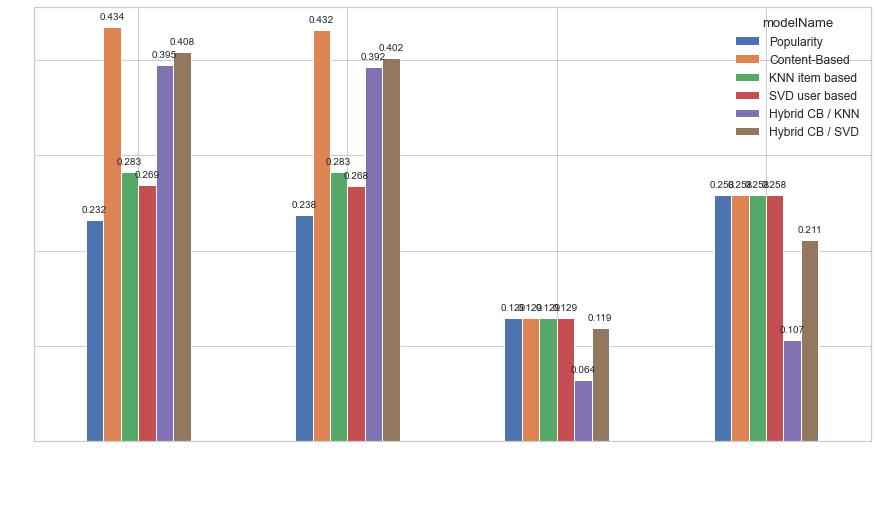

In [1171]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
ax.xaxis.label.set_color('white')        #setting up X-axis label color to yellow
ax.yaxis.label.set_color('white')          #setting up Y-axis label color to blue

ax.tick_params(colors='white')    #setting up X-axis tick color to red
ax.tick_params(colors='white')
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Surprise
## Model based CF

In [37]:
# data = interactions.groupby(['user_id', 'click_article_id']).size()
data = interactions[['user_id', 'click_article_id', 'weighted_average']]
data

user_id  click_article_id  weighted_average
1408       183            159359          0.010826
1403       183             96663          0.010826
363         64            119592          0.006901
2           24            162286          0.028490
370         64            236294          0.006901
...        ...               ...               ...
49127    12526            118696          0.001116
72508    21356            284221          0.006410
72497    21356             71518          0.006410
72496    21356             70413          0.006410
72503    21356            208084          0.006410

[159776 rows x 3 columns]

In [50]:
from surprise.model_selection import train_test_split
from surprise import Dataset
reader = Reader(rating_scale=(0, 1)) # We have implicit feedbacks and surprise does not deal with them goog
# I used 0 to 1 since I normalized the datas
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(interactions, reader)
algo = SVD()
trainset, testset = train_test_split(data, test_size=0.2)
algo.fit(trainset)
predictions = algo.test(testset)


In [57]:
from surprise import KNNBasic
sim_options = {'name': 'cosine',
               'user_based': False  # compute  similarities between items
               }
algo_knn_items = KNNBasic(sim_options=sim_options)
algo_knn_items.fit(trainset)
predictions_knn_items = algo_knn_items.test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [59]:
surprise_knn_items = SurpriseRecommender(predictions_knn_items)
print('Evaluating Surprise KNN items similarity')
surprise_global_similarity, surprise_detailed_similarity_df = sim_evaluator.evaluate_model(surprise_knn_items, -1, 100)
print('\nResults:\n%s' % surprise_global_similarity)
surprise_detailed_similarity_df.head(10)


Evaluating Surprise KNN items similarity
100 users processed
200 users processed
300 users processed
400 users processed
500 users processed
600 users processed
700 users processed
800 users processed
900 users processed
1000 users processed
1042 users processed

Results:
{'modelName': 'Surprise', 'interacted_count': 127818, 'sim@5': 0.2898844892546635, 'sim@10': 0.28952808236687205, 'mapk@5': 0.019261744966442933, 'mapk@10': 0.029050776910316777, 'recall@5': 0.1276770577998953, 'recall@10': 0.22349125340275938}


interacted_count     sim@5    sim@10  mapk@5   mapk@10  recall@5  \
43                961  0.285306  0.265640     0.0  0.000000  0.024038   
214               748  0.462770  0.349713     0.0  0.010000  0.015528   
309               708  0.316598  0.320401     0.0  0.000000  0.020833   
113               606  0.291859  0.337244     0.0  0.014286  0.029070   
3                 597  0.380901  0.469122     0.0  0.000000  0.031250   
48                561  0.273993  0.290004     0.0  0.000000  0.031847   
282               413  0.229790  0.314819     0.0  0.000000  0.041322   
7                 401  0.265017  0.445873     0.0  0.000000  0.037037   
99                401  0.355495  0.300475     0.0  0.000000  0.050000   
222               392  0.296641  0.298795     0.1  0.050000  0.052083   

     recall@10  user_id  
43    0.048077     5890  
214   0.031056    73574  
309   0.041667    15867  
113   0.058140    80350  
3     0.062500    15275  
48    0.063694     2151  
282   0.082645     4568  
7     0.037037    11521  
99    0.100000    12897  
222   0.104167    34541

In [60]:
sim_options = {'name': 'cosine',
               'user_based': True  # compute  similarities between users
               }
algo_knn_users = KNNBasic(sim_options=sim_options)
algo_knn_users.fit(trainset)
predictions_knn_user = algo_knn_users.test(testset)
surprise_knn_user = SurpriseRecommender(predictions_knn_user)
print('Evaluating Surprise KNN user similarity')
surprise_global_similarity, surprise_detailed_similarity_df = sim_evaluator.evaluate_model(surprise_knn_user, -1, 100)
print('\nResults:\n%s' % surprise_global_similarity)
surprise_detailed_similarity_df.head(10)


Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating Surprise KNN user similarity
100 users processed
200 users processed
300 users processed
400 users processed
500 users processed
600 users processed
700 users processed
800 users processed
900 users processed
1000 users processed
1042 users processed

Results:
{'modelName': 'Surprise', 'interacted_count': 127818, 'sim@5': 0.2898844892546635, 'sim@10': 0.28952808236687205, 'mapk@5': 0.019261744966442933, 'mapk@10': 0.029050776910316777, 'recall@5': 0.1276770577998953, 'recall@10': 0.22349125340275938}


interacted_count     sim@5    sim@10  mapk@5   mapk@10  recall@5  \
43                961  0.285306  0.265640     0.0  0.000000  0.024038   
214               748  0.462770  0.349713     0.0  0.010000  0.015528   
309               708  0.316598  0.320401     0.0  0.000000  0.020833   
113               606  0.291859  0.337244     0.0  0.014286  0.029070   
3                 597  0.380901  0.469122     0.0  0.000000  0.031250   
48                561  0.273993  0.290004     0.0  0.000000  0.031847   
282               413  0.229790  0.314819     0.0  0.000000  0.041322   
7                 401  0.265017  0.445873     0.0  0.000000  0.037037   
99                401  0.355495  0.300475     0.0  0.000000  0.050000   
222               392  0.296641  0.298795     0.1  0.050000  0.052083   

     recall@10  user_id  
43    0.048077     5890  
214   0.031056    73574  
309   0.041667    15867  
113   0.058140    80350  
3     0.062500    15275  
48    0.063694     2151  
282   0.082645     4568  
7     0.037037    11521  
99    0.100000    12897  
222   0.104167    34541

In [133]:
# from surprise import dump
# dump.dump('./dump_file', predictions_knn_user, algo_knn_users)
joblib.dump(predictions_knn_user, "cf_preds")

['cf_preds']

In [55]:

def get_top_n(predictions, n=10): # From Surprise github
    """Return the top-N recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.
    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [86]:
class SurpriseRecommender:
    
    MODEL_NAME = 'Surprise'
    
    def __init__(self, predictions):
        self.predictions = predictions
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        top_n = get_top_n(self.predictions, topn)
        top_n = get_top_n(predictions, n=10)
        items_to_ignore = [ x for x in trainset.all_items()]
        recommendations_df = pd.DataFrame(list(top_n[user_id]), columns=['click_article_id', 'predicted_rating'])\
                            .sort_values('predicted_rating', ascending=False).head(topn)
        recommendations_df['weighted_average'] = recommendations_df['predicted_rating']
        display(recommendations_df)
        return recommendations_df

surprise_model = SurpriseRecommender(predictions)

In [108]:
top_n = get_top_n(predictions, n=10)
user_id = list(top_n)[24]
recommendations_df = pd.DataFrame(list(top_n[user_id]), columns=['click_article_id', 'weight_CF'])\
                    .sort_values('weight_CF', ascending=False).head(5)
recommendations_df

click_article_id  weight_CF
0            360812   0.027908
1            363238   0.024851
2            360463   0.024851
3            361242   0.024271
4            363246   0.024164

In [1184]:
print('Evaluating Surprise model similarity')
surprise_global_similarity, surprise_detailed_similarity_df = sim_evaluator.evaluate_model(surprise_model, -1, 100)
print('\nResults:\n%s' % surprise_global_similarity)
surprise_detailed_similarity_df.head(10)


Evaluating Surprise model similarity
100 users processed
200 users processed


'mretics NAN'

300 users processed
400 users processed
500 users processed
600 users processed
700 users processed
800 users processed
900 users processed
1000 users processed
1043 users processed

Results:
{'modelName': 'Surprise', 'interacted_count': 127818, 'sim@5': 0.2924529462767013, 'sim@10': 0.2916730625603137, 'mapk@5': 0.015107062959411922, 'mapk@10': 0.02456714453119065, 'recall@5': 0.12655449441177183, 'recall@10': 0.24202750302212675}


interacted_count     sim@5    sim@10  mapk@5   mapk@10  recall@5  \
159               961  0.276181  0.261808    0.00  0.000000  0.023364   
901               748  0.410972  0.363540    0.00  0.000000  0.000000   
364               708  0.392932  0.356004    0.00  0.011111  0.010331   
929               606  0.331018  0.297363    0.00  0.000000  0.555556   
347               597  0.626673  0.396989    0.00  0.000000  0.166667   
67                561  0.274208  0.251101    0.00  0.000000  0.016077   
128               413  0.261405  0.303389    0.00  0.020000  0.041322   
276               401  0.326510  0.508125    0.00  0.000000  0.030864   
304               401  0.238402  0.289364    0.04  0.020000  0.053763   
553               392  0.272944  0.289818    0.00  0.000000  0.131579   

     recall@10  user_id  
159   0.046729     5890  
901   0.000000    73574  
364   0.020661    15867  
929   1.111111    80350  
347   0.166667    15275  
67    0.032154     2151  
128   0.082645     4568  
276   0.061728    11521  
304   0.107527    12897  
553   0.263158    34541

## average embeddings

In [1185]:
emb_df['average'] = emb_df.mean(axis=1)
interactions[['user_id', 'click_article_id', 'weighted_average']]
data = interactions[['user_id', 'click_article_id', 'weighted_average']]\
.merge(emb_df['average'], left_on="click_article_id", right_index=True)
data

user_id  click_article_id  weighted_average   average
1408       183            159359          0.010826 -0.016052
3051       388            159359          0.022602 -0.016052
7237      1261            159359          0.057930 -0.016052
2318       286            159359          0.013770 -0.016052
17876     3671            159359          0.008864 -0.016052
...        ...               ...               ...       ...
49127    12526            118696          0.001116  0.029221
72508    21356            284221          0.006410  0.008070
72497    21356             71518          0.006410  0.027541
72496    21356             70413          0.006410  0.036151
72503    21356            208084          0.006410  0.019245

[159776 rows x 4 columns]

In [1186]:
reader = Reader(rating_scale=(0, 1))
# # The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(data.drop('weighted_average', axis=1), reader)

algo = SVD()
trainset, testset = train_test_split(data, test_size=0.2)
algo.fit(trainset)
predictions = algo.test(testset)

In [1187]:
Surprise_recommend_model_emb = SurpriseRecommender(predictions)
print('Evaluating Embedding Suprise CB model...')

surprise_emb_global_metrics, surprise_emb_detailed_results_df = sim_evaluator.evaluate_model(Surprise_recommend_model_emb, -1, 100)
print('\nGlobal metrics:\n%s' % surprise_emb_global_metrics)
surprise_emb_detailed_results_df.head(10)

Evaluating Embedding Suprise CB model...
100 users processed
200 users processed
300 users processed
400 users processed
500 users processed
600 users processed
700 users processed
800 users processed
900 users processed
1000 users processed
1043 users processed

Global metrics:
{'modelName': 'Surprise', 'interacted_count': 127820, 'sim@5': 0.2900918536744584, 'sim@10': 0.28941540898205675, 'mapk@5': 0.020478927203065107, 'mapk@10': 0.027281632001459683, 'recall@5': 0.12657081685297747, 'recall@10': 0.23661909377220594}


interacted_count     sim@5    sim@10  mapk@5   mapk@10  recall@5  \
159               961  0.265373  0.269184     0.0  0.000000  0.023364   
902               748  0.516443  0.391201     0.0  0.050000  0.000000   
365               708  0.409991  0.336435     0.0  0.011111  0.010331   
930               606  0.372652  0.325538     0.0  0.000000  0.555556   
348               597  0.561841  0.412999     0.1  0.050000  0.166667   
67                561  0.250631  0.274273     0.0  0.000000  0.016077   
128               413  0.288744  0.270707     0.0  0.000000  0.041322   
305               401  0.219948  0.260245     0.0  0.000000  0.053763   
277               401  0.412168  0.516258     0.0  0.010000  0.030864   
554               392  0.239430  0.254421     0.0  0.000000  0.131579   

     recall@10  user_id  
159   0.046729     5890  
902   0.000000    73574  
365   0.020661    15867  
930   1.111111    80350  
348   0.200000    15275  
67    0.032154     2151  
128   0.082645     4568  
305   0.107527    12897  
277   0.061728    11521  
554   0.263158    34541

# Implicit

In [38]:
import implicit

In [125]:
class ImplicitRecommender:
    
    MODEL_NAME = 'Implicit MF users'
    
    def __init__(self, model, user_items, mode="user", items_df=None):
        self.items_df = items_df
        self.user_items = user_items
        self.model = model
        self.mode = mode
        
    def get_model_name(self):
        return self.MODEL_NAME

    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        if self.mode == "user":

            recommendations_df = pd.DataFrame(self.model.recommend(user_id, self.user_items, filter_already_liked_items=True), columns=['click_article_id', 'weighted_average'])\
            .sort_values("weighted_average", ascending=False).head(topn)
            recommendations_df = recommendations_df[~recommendations_df['click_article_id'].isin(items_to_ignore)] \
#                                .sort_values('weighted_average', ascending = False) \
        else:
            last_read_article = df[df['user_id'] == user_id].sort_values('click_timestamp', ascending=False)['click_article_id'][0:1].values[0]
#             print(last_read_article)
            recommendations_df = pd.DataFrame(self.model.similar_items(last_read_article), columns=['click_article_id', 'weighted_average'])\
            .sort_values("weighted_average", ascending=False).head(topn)
            recommendations_df = recommendations_df[~recommendations_df['click_article_id'].isin(items_to_ignore)]
        return recommendations_df


In [40]:
from scipy.sparse import coo_matrix

In [110]:
 #sparse matrix of item/user/confidence weights
item_user_matrix = sparse.csr_matrix(interactions_train[['click_article_id','user_id', 'weighted_average']])

In [111]:
import implicit
reg_items_train = sparse.csr_matrix(
    (
        interactions_train['weighted_average'], 
       (
           interactions_train['click_article_id'], 
            interactions_train['user_id']
       )
    
    )
)
reg_items_test = sparse.csr_matrix(
    (
        interactions_test['weighted_average'], 
       (
           interactions_test['click_article_id'],
           interactions_test['user_id']
            
       )
    
    )
)


## ALS

In [112]:
model = implicit.als.AlternatingLeastSquares(factors=50)
model.fit(reg_items_train)

  0%|          | 0/15 [00:00<?, ?it/s]

In [113]:
model = implicit.als.AlternatingLeastSquares(factors=50)

# train the model on a sparse matrix of item/user/confidence weights
model.fit(reg_items_train)

# recommend items for a user
user_items = reg_items_train.T.tocsr()
recommendations = model.recommend(24, user_items)
recommendations

  0%|          | 0/15 [00:00<?, ?it/s]

[(74722, 0.029444143),
 (237807, 0.006905891),
 (206785, 0.0062200725),
 (205973, 0.0061650183),
 (202320, 0.0061525106),
 (61393, 0.0061239153),
 (236613, 0.005912587),
 (337143, 0.0054778904),
 (207603, 0.0052125566),
 (202476, 0.00486337)]

In [1194]:
model.similar_items(158915)

[(158915, 0.99999994),
 (214206, 0.6768777),
 (214109, 0.6072964),
 (107039, 0.5723189),
 (160894, 0.5654353),
 (206938, 0.53916705),
 (166462, 0.53283113),
 (297639, 0.51631844),
 (87179, 0.5109745),
 (283627, 0.5032671)]

In [115]:
implicit_model = ImplicitRecommender(model, user_items, "user")
# implicit_model.recommend_items(24, interactions_train_indexed)

In [116]:
implicit_model = ImplicitRecommender(model, user_items, "user")

print('Evaluating Implicid ALS user similarity')
implicit_global_similarity, implicit_detailed_similarity_df = sim_evaluator.evaluate_model(implicit_model, -1, 100)
print('\nResults:\n%s' % implicit_global_similarity)
implicit_detailed_similarity_df.head(10)


Evaluating Implicid ALS user similarity
100 users processed
200 users processed
300 users processed
400 users processed
500 users processed
600 users processed
700 users processed
800 users processed
900 users processed
1000 users processed
1042 users processed

Results:
{'modelName': 'Implicit ALS ', 'interacted_count': 127818, 'sim@5': 0.26034585745828376, 'sim@10': 0.2604577584068933, 'mapk@5': 0.0, 'mapk@10': 0.0, 'recall@5': 0.06313523062201003, 'recall@10': 0.08474657176434515}


interacted_count     sim@5    sim@10  mapk@5  mapk@10  recall@5  \
43                961  0.182725  0.212152     0.0      0.0  0.009615   
214               748  0.299483  0.273440     0.0      0.0  0.015528   
309               708  0.301333  0.314187     0.0      0.0  0.000000   
113               606  0.227523  0.229585     0.0      0.0  0.029070   
3                 597 -0.029197  0.097010     0.0      0.0  0.000000   
48                561  0.226275  0.268326     0.0      0.0  0.000000   
282               413  0.295927  0.221342     0.0      0.0  0.041322   
7                 401  0.307423  0.264738     0.0      0.0  0.000000   
99                401  0.273478  0.245766     0.0      0.0  0.050000   
222               392  0.237268  0.249752     0.0      0.0  0.052083   

     recall@10  user_id  
43    0.009615     5890  
214   0.031056    73574  
309   0.000000    15867  
113   0.040698    80350  
3     0.000000    15275  
48    0.000000     2151  
282   0.082645     4568  
7     0.000000    11521  
99    0.100000    12897  
222   0.104167    34541

## Matrix Factorization

In [120]:
model = implicit.lmf.LogisticMatrixFactorization(factors=50, learning_rate=0.01, iterations=30, num_threads=6)

# train the model on a sparse matrix of item/user/confidence weights
model.fit(reg_items_train)

# recommend items for a user
user_items = reg_items_train.T.tocsr()
recommendations = model.recommend(24, user_items)
recommendations

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 10.37it/s]


[(83799, 27.32317),
 (96269, 25.571867),
 (270675, 25.334967),
 (29838, 24.960388),
 (114535, 24.758667),
 (284946, 23.524801),
 (144866, 23.294739),
 (336476, 23.286028),
 (264903, 23.184797),
 (225699, 23.163555)]

Item based MF

In [122]:
implicit_model = ImplicitRecommender(model, user_items, "items")

In [124]:
print('Evaluating Implicid MF items similarity')
implicit_global_similarity, implicit_detailed_similarity_df = sim_evaluator.evaluate_model(implicit_model, -1, 100)
print('\nResults:\n%s' % implicit_global_similarity)
implicit_detailed_similarity_df.head(10)


Evaluating Implicid MF items similarity
100 users processed
200 users processed
300 users processed
400 users processed
500 users processed
600 users processed
700 users processed
800 users processed
900 users processed
1000 users processed
1042 users processed

Results:
{'modelName': 'Implicit MF items', 'interacted_count': 127818, 'sim@5': 0.2244235081910687, 'sim@10': 0.22186078259244577, 'mapk@5': 0.0, 'mapk@10': 0.0, 'recall@5': 0.13602551717778008, 'recall@10': 0.24890288107239064}


interacted_count     sim@5    sim@10  mapk@5  mapk@10  recall@5  \
43                961  0.240723  0.222142     0.0      0.0  0.024038   
214               748  0.224213  0.246683     0.0      0.0  0.015528   
309               708  0.190689  0.149714     0.0      0.0  0.020833   
113               606  0.151967  0.238427     0.0      0.0  0.029070   
3                 597  0.049299  0.016980     0.0      0.0  0.031250   
48                561  0.188249  0.180063     0.0      0.0  0.031847   
282               413  0.216680  0.235801     0.0      0.0  0.041322   
7                 401  0.242875  0.226619     0.0      0.0  0.046296   
99                401  0.314099  0.259942     0.0      0.0  0.050000   
222               392  0.145871  0.218541     0.0      0.0  0.052083   

     recall@10  user_id  
43    0.043269     5890  
214   0.024845    73574  
309   0.033333    15867  
113   0.058140    80350  
3     0.062500    15275  
48    0.057325     2151  
282   0.074380     4568  
7     0.083333    11521  
99    0.100000    12897  
222   0.093750    34541

User based MF

In [126]:
implicit_model = ImplicitRecommender(model, user_items, "user")
print('Evaluating Implici MF users similarity')
implicit_global_similarity, implicit_detailed_similarity_df = sim_evaluator.evaluate_model(implicit_model, -1, 100)
print('\nResults:\n%s' % implicit_global_similarity)
implicit_detailed_similarity_df.head(10)

Evaluating Implici MF users similarity
100 users processed
200 users processed
300 users processed
400 users processed
500 users processed
600 users processed
700 users processed
800 users processed
900 users processed
1000 users processed
1042 users processed

Results:
{'modelName': 'Implicit MF users', 'interacted_count': 127818, 'sim@5': 0.2176442059008753, 'sim@10': 0.2175750625270668, 'mapk@5': 0.0, 'mapk@10': 0.0, 'recall@5': 0.13602551717778008, 'recall@10': 0.27205103435556016}


interacted_count     sim@5    sim@10  mapk@5  mapk@10  recall@5  \
43                961  0.221362  0.211081     0.0      0.0  0.024038   
214               748  0.223060  0.237132     0.0      0.0  0.015528   
309               708  0.249033  0.225589     0.0      0.0  0.020833   
113               606  0.171392  0.099799     0.0      0.0  0.029070   
3                 597  0.059583  0.095458     0.0      0.0  0.031250   
48                561  0.236012  0.220707     0.0      0.0  0.031847   
282               413  0.287496  0.255249     0.0      0.0  0.041322   
7                 401  0.230851  0.273444     0.0      0.0  0.046296   
99                401  0.282482  0.260616     0.0      0.0  0.050000   
222               392  0.136888  0.191252     0.0      0.0  0.052083   

     recall@10  user_id  
43    0.048077     5890  
214   0.031056    73574  
309   0.041667    15867  
113   0.058140    80350  
3     0.062500    15275  
48    0.063694     2151  
282   0.082645     4568  
7     0.092593    11521  
99    0.100000    12897  
222   0.104167    34541

# LightFM

In [405]:
interactions

user_id        session_id  click_article_id  click_timestamp  \
0              0  1506825423271737             68866    1506826858020   
1              0  1506825423271737            157541    1506826828020   
2              0  1507340000920377             96755    1507340033155   
3              0  1507340000920377            313996    1507340063155   
4              0  1507385847186982            160158    1507388090915   
...          ...               ...               ...              ...   
2988176   322894  1508211292336313            168401    1508211468695   
2988177   322895  1508211314125317             63746    1508211346889   
2988178   322895  1508211314125317            289197    1508211316889   
2988179   322896  1508211376302329             30760    1508211672520   
2988180   322896  1508211376302329            157507    1508211702520   

         weighted_average  
0                 0.05793  
1                 0.05793  
2                 0.05793  
3                 0.05793  
4                 0.05793  
...                   ...  
2988176           0.05793  
2988177           0.05793  
2988178           0.05793  
2988179           0.05793  
2988180           0.05793  

[2988181 rows x 5 columns]

In [132]:
art_emb = articles_meta_df.merge(emb_df, left_on='click_article_id', right_index=True, how="right")
art_emb.drop(['created_at_ts', 'publisher_id'], axis=1, inplace=True)

articles_lightfm = art_emb.to_dict(orient="records")
interactions_lightfm = interactions[["user_id", "click_article_id", "weighted_average"]].to_dict(orient="records")

# articles_feat_lightfm = art_emb.to_dict(orient="records")
# interactions_feat_lightfm = interactions.to_dict(orient="records")

In [134]:
def get_articles():
    return articles_lightfm
def get_interactions():
    return interactions_lightfm

Fitting dataset with user/items ids

In [136]:
from lightfm.data import Dataset
from lightfm import LightFM

dataset = Dataset()
dataset.fit(
        interactions['user_id'].unique(),
        art_emb['click_article_id'].unique()
)

In [137]:
num_users, num_items = dataset.interactions_shape()
print('Num users: {}, num_items {}.'.format(num_users, num_items))

Num users: 1044, num_items 364047.


Build item features with all embeddings + category + word count

Fit partial illustration

In [140]:
dataset.fit_partial(items=(x['click_article_id'] for x in get_articles()),
                    item_features = art_emb.drop("click_article_id", axis=1).itertuples())

Splitting train / test

In [142]:

from sklearn.model_selection import train_test_split

(train_interactions, train_weights) = dataset.build_interactions(((x['user_id'], x['click_article_id'])
                                                      for x in interactions_train.to_dict(orient="records")))

(test_interactions, test_weights) = dataset.build_interactions(((x['user_id'], x['click_article_id'])
                                                      for x in interactions_test.to_dict(orient="records")))


## Warp

In [145]:
from lightfm import LightFM
model = LightFM(
    no_components=250,
    learning_rate=0.05,
    loss='warp',
    random_state=42)

model.fit(
    train_interactions,
    item_features=item_features,
    sample_weight=train_weights,
    epochs=5, num_threads=7, verbose=True)

Epoch: 100%|█████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.21s/it]


In [146]:
(interactions, weights) = dataset.build_interactions(((x['user_id'], x['click_article_id'])
                                                      for x in interactions_lightfm))

print(repr(interactions))

<1044x364047 sparse matrix of type '<class 'numpy.int32'>'
	with 159776 stored elements in COOrdinate format>


In [150]:
class WARPRecommender:
    
    MODEL_NAME = 'Warp'
    
    def __init__(self, model, items_df=None):
        self.items_df = items_df
        self.model = model
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_ids, items_to_ignore=None, topn=10):
        user_ids = np.array([user_ids.item()])
        for user_id in [user_ids]:
            interacted_values_testset = interactions_test_indexed.loc[user_id]#.sort_values('weighted_average', ascending=False)

            if type(interacted_values_testset['click_article_id']) == pd.Series:
                person_interacted_items_testset = interacted_values_testset['click_article_id']
            else:
                person_interacted_items_testset = [int(interacted_values_testset['click_article_id'])]  
            interacted_items = person_interacted_items_testset.values.tolist()
            to_predict_df = art_emb[~art_emb.index.isin(interacted_items)]

            scores = model.predict(
                user_id,
                to_predict_df['click_article_id'].values.tolist(),
                item_features=item_features)
            to_predict_df['scores'] = scores
            to_predict_df['weighted_average'] = to_predict_df['scores']
    #         df = pd.DataFrame([user_id, ])
            to_predict_df = to_predict_df.sort_values('scores', ascending=False)[:10]
    #         display(items_filtered[['questions_title', 'question_features']])
            return to_predict_df[['click_article_id', 'category_id', 'words_count', 'scores', 'weighted_average']]
#             except:
#             print("error", user_id)
#             return pd.DataFrame({'click_article_id': [0], 'category_id': [0], 'words_count': [0], 'scores': [0], 'weighted_average': [0]})

            
    
item_ids = articles_meta_df['click_article_id'].values.tolist() 
WARPrecommender_model = WARPRecommender(model)

In [455]:
print('Evaluating WARP model similarity')
Warp_global_similarity, Warp_detailed_similarity_df = sim_evaluator.evaluate_model(WARPrecommender_model, -1, 100)
print('\nResults:\n%s' % Warp_global_similarity)
display(Warp_detailed_similarity_df.head(10))
# del Warp_global_similarity
gc.collect()

Evaluating WARP model similarity
100 users processed
200 users processed
300 users processed
400 users processed
500 users processed
600 users processed
700 users processed
800 users processed
900 users processed
1000 users processed
1042 users processed

Results:
{'modelName': 'Warp', 'interacted_count': 127818, 'sim@5': 0.25150895883951585, 'sim@10': 0.24601014410632227, 'mapk@5': 0.005123042505592842, 'mapk@10': 0.006144173553090131, 'recall@5': 0.13602551717778008, 'recall@10': 0.27205103435556016}


interacted_count     sim@5    sim@10  mapk@5  mapk@10  recall@5  \
43                961  0.318824  0.258929     0.0     0.00  0.024038   
214               748  0.319896  0.300311     0.0     0.00  0.015528   
309               708  0.327199  0.333516     0.0     0.05  0.020833   
113               606  0.146458  0.107045     0.0     0.00  0.029070   
3                 597  0.026037  0.173654     0.0     0.00  0.031250   
48                561  0.253363  0.282891     0.0     0.00  0.031847   
282               413  0.270123  0.217936     0.0     0.00  0.041322   
7                 401  0.302873  0.257478     0.0     0.00  0.046296   
99                401  0.195809  0.181307     0.0     0.00  0.050000   
222               392  0.170557  0.201244     0.0     0.00  0.052083   

     recall@10  user_id  
43    0.048077     5890  
214   0.031056    73574  
309   0.041667    15867  
113   0.058140    80350  
3     0.062500    15275  
48    0.063694     2151  
282   0.082645     4568  
7     0.092593    11521  
99    0.100000    12897  
222   0.104167    34541

8

In [473]:
joblib.dump(model, "lightfm_model")
joblib.dump(interactions_train_indexed['click_article_id'], "interacted_items")

['interacted_items']

In [127]:
#### Define a new model instance
model = LightFM(loss='warp',
                item_alpha=1e-6,
                no_components=NUM_COMPONENTS)

# Fit the hybrid model. Note that this time, we pass
# in the item features matrix.
model = model.fit(train_interactions,
                item_features=item_features,
                epochs=NUM_EPOCHS,
                num_threads=NUM_THREADS)

NameError: name 'LightFM' is not defined

In [463]:
def sample_recommendation(model, data, user_ids):
    n_users, n_items = data['train'].shape
    for user_id in user_ids:
        known_positives = data['item_labels'][data['train'].tocsr()                                    
                          [user_id].indices]
        
        scores = model.predict(user_id, np.arange(n_items))

        top_items = data['item_labels'][np.argsort(-scores)]

        print("User %s" % user_id)
        print("     Known positives:")
        
        for x in known_positives[:3]:
            print("        %s" % x)
        
        print("     Recommended:")
        
        for x in top_items[:3]:
            print("        %s" % x)
            
sample_recommendation(model, data, [3])

NameError: name 'data' is not defined

In [196]:
class LightFMRecommender:
    
    MODEL_NAME = 'Implicit Regular'
    
    def __init__(self, model, items_features, items_df=None):
        self.items_df = items_df
        self.items_features = items_features
        self.model = model

        
    def get_model_name(self):
        return self.MODEL_NAME
    
    def similar_items(self, item_id, n=10):
        item_representations = self.items_features.dot(model.item_embeddings)

        # Cosine similarity
        scores = item_representations.dot(item_representations[item_id, :])
        item_norms = np.linalg.norm(item_representations, axis=1)
        scores /= item_norms

        best = np.argpartition(scores, -n)[-n:]
        return sorted(zip(best, scores[best] / item_norms[item_id]), 
                      key=lambda x: -x[1])
    
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
       
        last_read_article = df[df['user_id'] == user_id].sort_values('click_timestamp', ascending=False)['click_article_id'][0:1].values[0]
#             print(last_read_article)
        recommendations_df = pd.DataFrame(self.similar_items(last_read_article), columns=['click_article_id', 'weighted_average'])\
        .sort_values("weighted_average", ascending=False).head(topn)
        print(recommendations_df)
        return recommendations_df
    
item_ids = articles_meta_df['click_article_id'].tolist() 

lightfm_recommender = LightFMRecommender(model, item_features)
# last_read_article = df[df['user_id'] == 5890].sort_values('click_timestamp', ascending=False)['click_article_id'][0:1].values[0]
# similar_items(last_read_article, item_features, model)

# COSMOS DB

## Configuration

In [1147]:
import azure.cosmos.cosmos_client as cosmos_client
import azure.cosmos.exceptions as exceptions
from azure.cosmos.partition_key import PartitionKey

HOST = "https://cosmos-p9.documents.azure.com:443/" 
MASTER_KEY = "GF09VIvWYaZXHkwTH8meidwxZ9DwU7RZQHCUakXmKBrDRmxWc4oZ3YAzmfyeO0eNz2YPOnO7Pq9r4hZeR2WAXQ=="#config.settings['master_key']
DATABASE_ID = "reco" 
CONTAINER_ID = "Recos"

client = cosmos_client.CosmosClient(HOST, {'masterKey': MASTER_KEY} )

def find_container(db, id):
    containers = list(db.query_containers(
        {
            "query": "SELECT * FROM r WHERE r.id=@id",
            "parameters": [
                { "name":"@id", "value": id }
            ]
        }
    ))

    if len(containers) > 0:
        print('Container with id \'{0}\' was found'.format(id))
    else:
        print('No container with id \'{0}\' was found'. format(id))
    return containers

db = client.get_database_client(DATABASE_ID)
container = np.array(find_container(db, CONTAINER_ID))
container_reco = db.get_container_client('Recos')
container_pop = db.get_container_client('Popular')

Container with id 'Recos' was found


In [697]:
users = interactions_train.groupby('user_id').size().reset_index().user_id.values
users

array([    24,     51,     64, ..., 210567, 224325, 253733], dtype=int64)

## Popular recommandations

In [712]:
def create_user_recos(user_id):
    return CB_recommend_model_W.recommend_items(user_id, interactions_train) 
recos = []
with tqdm(total=1000) as pbar:
    for user_id in users[0:1000]:
        recos.append(create_user_recos(user_id))
        pbar.update(1)
    
len(recos)

  0%|          | 0/1000 [00:00<?, ?it/s]

1000

## Content based recommandations

In [1149]:
def create_users_items(container):
    print('Creating Items')
    print('\n1.1 Create Item\n')

    for i, (user_id, reco) in enumerate(zip(users, recos)):
        print("creating",  reco.click_article_id.values)
        user = {'id' : str(i),
                'user_id' : str(user_id),
            'items' :  reco.click_article_id.values.tolist()
            }
        container.create_item(body=user)

def create_popular_items(container):
    print('Creating PopularItems')

    for i, article_id in enumerate(popularity_df[0:5]['click_article_id']):
        recos = {'id' : str(i),
                'article_id' : str(article_id)
            }
        container.create_item(body=recos)


create_popular_items(container_pop)

# create_users_items(container_reco)

Creating PopularItems


# Azure Deployment

In [469]:
import azureml.core
from azureml.core import Workspace
from azureml.core import Model
from azureml.core.resource_configuration import ResourceConfiguration
from azureml.core.webservice import AciWebservice, AksWebservice, Webservice
from azureml.core.model import InferenceConfig
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies

In [486]:
ws = Workspace.from_config('E:\OCR\P9\config.json')

cb_preds = Model.register(workspace = ws,
                       model_path= 'predictions',
                       model_name = 'cb_preds',
                       description = 'Recommendation model with Surprise lib')
cf_preds = Model.register(workspace = ws,
                       model_path= 'cf_preds',
                       model_name = 'cf_preds',
                       description = 'Recommendation model with SVD factorization')



Registering model reco_model


In [479]:
interactions_train_indexed['click_article_id'].to_csv("interacted_items.csv")

In [497]:
from azureml.core.model import Model
from azureml.core import Workspace, Dataset
from azureml.core.webservice import AciWebservice
from azureml.core.model import InferenceConfig
from azureml.core.environment import Environment
import joblib
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.webservice import LocalWebservice
import  json

 

 
p9env = Environment(workspace=ws, name = 'p9env')
p9env.python.conda_dependencies = CondaDependencies.create(pip_packages=[
    'azureml-defaults',
    'numpy',
    'joblib',
    'scikit-surprise',
    'scikit-learn',
    'pandas',
    'azure.storage.blob '
    
])
env_variables={
    "subscription_id": os.environ["AZURE_SUB_ID"],
    "resource_group": "ocrp9",
    "workspace_name": "ocr-p9", 
    "blob_credentials": os.environ["AZURE_ADLS_CREDS"]
}
p9env.environment_variables = env_variables
aci_config = AciWebservice.deploy_configuration(cpu_cores=1.8, memory_gb=4, location="francecentral") #deployment automatically adds 0.2 cores and 1Gb ram...
 
inference_config = InferenceConfig(entry_script="score.py", environment=p9env)
 
print("Inference config setted")
 
print("DEPLOYING")
service = Model.deploy(workspace=ws,
                name='recommandation-model',
                models=[cb_preds, cf_preds],
                inference_config=inference_config,
                deployment_config=aci_config,
                overwrite=True)
# Wait for the deployment to complete
service.wait_for_deployment(True)

print(service.get_logs())

Inference config setted
DEPLOYING


KeyboardInterrupt: 